In [94]:
import time
from statsmodels.tsa.vector_ar.var_model import VAR
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import pickle


import warnings
warnings.filterwarnings("ignore")

In [95]:
def restore_differenced(periods, df_original, df_differences):
    '''
    from: https://stackoverflow.com/questions/34918013/undo-a-series-diff
    '''
    restored = df_original.copy()
    restored.iloc[periods:] = np.nan
    for d, val in df_differences.iloc[periods:].iterrows():
        restored.iloc[d] = restored.iloc[d - periods] + val
    return restored

In [96]:
def log_score_function(actual, predicted, var):
    '''
    Function that calculates the log scoring function:
    
    L = 0.5 * sum_j (ln(var_j) + (y - y_hat)^2 / var_j)
    
    '''
    var[var == 0] = np.nan
    const = np.log(2 * np.pi)
    L = 0.5 * np.nansum(np.log(var) + (actual - predicted)**2 / var + const, axis=1)
    return L

In [250]:
n_sys_VAR = 1000
n_data_VAR = 70000

In [253]:
data =  pd.read_csv('../../../Data/pv_power_df_5day_capacity_scaled.csv', index_col='datetime')
uk_pv = pd.read_csv('../../../Data/system_metadata_location_rounded.csv')
uk_pv['ss_id_string'] = uk_pv['ss_id'].astype('str')
data_multiple = data.iloc[:, :n_sys_VAR][:n_data_VAR]

#SELECTING ONLY LONDON LOCATIONS
london_locations = np.array([2784, 2814, 2828, 3236, 3239, 3250, 3311, 3443, 4002, 4033, 6648,
6673, 6675, 6796, 7060, 7118, 7149, 7163, 7173, 7177, 7190,
7277, 7349, 7368, 7452, 7521, 7603])
london_locations = [str(a) for a in london_locations]
data_multiple = data_multiple[london_locations]
n_sys_VAR = 27

capacities = uk_pv[uk_pv.ss_id_string.isin(data_multiple.reset_index().columns)].set_index('ss_id_string')['kwp'].values * 1000


# Do the same for other benchmarks

## Uncertainty Intervals

By using a state space formulation, we can perform simulations of future values. The mathematical details are described in Hyndman and Athanasopoulos [2] and in the documentation of HoltWintersResults.simulate.

Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice, 2nd edition. OTexts, 2018.

In [254]:
models_list = ['persistence','yesterday','hourly_average' , 'VAR', 'SimpleExpSmoothing', 'ExponentialSmoothing',]

MAE_results = dict.fromkeys(models_list)
MAE_results_full = dict.fromkeys(models_list)
NLPD_results = dict.fromkeys(models_list)
NLPD_results_upper = dict.fromkeys(models_list)
NLPD_results_lower = dict.fromkeys(models_list)
predictions_results = dict.fromkeys(models_list)

#FIXED WINDOW OF 5000 train and 24 test, the 5000 train slide forward
length_window = 96 * 10
max_t = 14000 #len(data_multiple) - length_window - 24
#HERE BUILDING ARRAY OF STARTING ts
data_multiple.index = pd.to_datetime(data_multiple.index)
array_of_indices = data_multiple.reset_index()[(data_multiple.reset_index().datetime.dt.hour > 9) & (data_multiple.reset_index().datetime.dt.hour < 14)].index.values
# range_idx = array_of_indices[10000:max_t:50]
        
range_idx = np.array([ 1806,  2449,  3043,  3637,  4280,  4874,  5468,  6062,  6705,
        7299,  7893,  8487,  9130,  9723, 10366, 10960, 11554, 12148,
       12791, 13385, 13979, 14573, 15216, 15810, 16393, 17031, 17625,
       18219, 18813, 19456, 20050, 20644, 21238, 21881, 22475, 23069,
       23663, 24306, 24900, 25494, 26088, 26731, 27325, 27919, 28538,
       29132, 29726, 30320, 30963, 31557, 32151, 32745, 33388, 33982,
       34576, 35170, 35813, 36407, 37001, 37595, 38238, 38832, 39426,
       40020, 40663, 41257, 41851, 42494, 43088, 43682, 44295, 44888,
       45531, 46125, 46706, 47288, 47926, 48520, 49101, 49744])
    
for model_type in models_list:
    print(f'Getting results for {model_type}')
    t1 = time.time()

    errors = np.zeros((24, n_sys_VAR))
    predictions_history = np.zeros((24, n_sys_VAR))
    nlpds = np.zeros((24))
    
    for t in range_idx:
        data_multiple_iter = data_multiple.iloc[t:t+length_window + 24]
        data_multiple_train = data_multiple_iter.iloc[:length_window] 
        data_multiple_test = data_multiple_iter[length_window:]  

        if model_type == 'VAR':

            data_VAR = data_multiple_train.diff().diff(96).dropna()

            #CREATE MODEL AND PREDICT NEXT 24
            model = VAR(data_VAR)
            model_fit = model.fit()
            lag_order = model_fit.k_ar
            preds = model_fit.forecast(data_VAR.values[-lag_order:], 24)
            if len(preds[preds>10]) > 0:
                print('Careful, a prediction is higher than 10!')
            #evaluate forecast
            df_forecast = pd.DataFrame(preds, index=data_multiple_test.index, columns=data_VAR.columns)

            data_total = pd.concat([data_VAR,df_forecast], axis=0).reindex(data_multiple_iter.index).reset_index().drop(columns = ['datetime'])

            data_reset = data_total.iloc[1:].reset_index().drop(columns=['index'])
            restored = restore_differenced(96, data_multiple_iter.diff().dropna(), data_reset)
            restored = restored.reindex(data_multiple_iter.index).reset_index().drop(columns=['datetime'])
            restored_twice = restore_differenced(1, data_multiple_iter, restored)

            #CLIPPING PREDICTIONS BETWEEN 0 AND 1
            restored_twice = restored_twice.clip(0,1)
            predictions = restored_twice.iloc[-24:]    

        elif model_type == 'persistence':
            predictions = data_multiple_train.iloc[-1].values
            predictions =  np.repeat(predictions[np.newaxis, :], 24, axis=0)

        elif model_type == 'yesterday':
            predictions = np.zeros((1,n_sys_VAR))
            previous_day = data_multiple_train.iloc[-96:].values
            for i in range(24):
                pred = previous_day[-96 + i][np.newaxis, :]
                predictions = np.concatenate((predictions, pred))
            predictions = predictions[1:]

        elif model_type == 'hourly_average':
            predictions = np.zeros((1,n_sys_VAR))
            previous_hour = data_multiple_train.iloc[-12:].values
            for i in range(24):
                pred = previous_hour.mean(axis=0)[np.newaxis, :]
                predictions = np.concatenate((predictions, pred))
                #HERE I append the latest prediction and remove the oldest observation
                previous_hour = np.concatenate((previous_hour, pred), axis=0)[1:]
            predictions = predictions[1:]
            
            
        elif model_type == 'SimpleExpSmoothing':
            predictions = np.zeros((24, 1))
            variances = np.zeros((24, 1))
            for ts in range(data_multiple_train.shape[1]):
                model = SimpleExpSmoothing(data_multiple_train.iloc[:,ts], initialization_method="estimated")
                model_fit = model.fit()
                
                fcast = model_fit.forecast(24).values[:, np.newaxis]
                predictions = np.concatenate((predictions, fcast), axis=1)
                
                var = model_fit.simulate(nsimulations = 24, anchor = 'end', repetitions = 1000 ).var(axis=1).values[:, np.newaxis]
                
                var_low_bound = (fcast**2 / 4)
                var_upper_bound = ((1-fcast)**2 / 4)
                var = np.maximum(var_low_bound, var)
                var = np.minimum(var_upper_bound, var)
                
                variances = np.concatenate((variances, var), axis=1)
                
                
            predictions = predictions[:, 1:]
            variances = variances[:, 1:]
            
            nlpd = log_score_function(data_multiple_iter.iloc[-24:].values, predictions, variances) 
            nlpds = np.concatenate((nlpds, nlpd))   
            
            
        elif model_type == 'ExponentialSmoothing':
            predictions = np.zeros((24, 1))
            variances = np.zeros((24, 1))
            for ts in range(data_multiple_train.shape[1]):
                model = ExponentialSmoothing(data_multiple_train.iloc[:,ts], 
                                             seasonal_periods=96,
                                             seasonal="add",
                                             initialization_method="estimated")
                model_fit = model.fit()
                fcast = model_fit.forecast(24).values[:, np.newaxis]
                predictions = np.concatenate((predictions, fcast), axis=1)
                
                var = model_fit.simulate(nsimulations = 24, anchor = 'end', repetitions = 1000 ).var(axis=1).values[:, np.newaxis]
                
                var_low_bound = (fcast**2 / 4)
                var_upper_bound = ((1-fcast)**2 / 4)
                var = np.maximum(var_low_bound, var)
                var = np.minimum(var_upper_bound, var)
                
                variances = np.concatenate((variances, var), axis=1)
                
            predictions = predictions[:, 1:]
            variances = variances[:, 1:]
            
            nlpd = log_score_function(data_multiple_iter.iloc[-24:].values, predictions, variances) 
            nlpds = np.concatenate((nlpds, nlpd))   

            
        #THIS WAY WE REDUCE THE ERROR FURTHER USING A SIMPLE TRICK OF CLIPPING PREDICTIONS OUTSIDE DOMAIN
        predictions = predictions.clip(0,1)
        predictions_history = np.concatenate((predictions_history, predictions))    
        
        #Get error
        error = abs((predictions - data_multiple_iter.iloc[-24:]).values)
        errors = np.concatenate((errors, error))       
        
        t2 = time.time()
        print(f'{model_type} calculation time: %2.2f secs' % (t2-t1))

    predictions_history = predictions_history.reshape(-1, 24, n_sys_VAR)[1:]
    predictions_results[model_type] = predictions_history
    
    errors = errors.reshape(-1, 24, n_sys_VAR)[1:]
    MAE_hsteps = np.mean(np.mean(errors, axis=0), axis=1)    
    MAE_results[model_type] = MAE_hsteps
        
    MAE_hsteps_full = errors 
    MAE_results_full[model_type] = MAE_hsteps_full
    
    if (model_type == 'SimpleExpSmoothing') or (model_type == 'ExponentialSmoothing'):
        nlpds = nlpds.reshape(-1, 24)[1:]
        NLPD_results[model_type] = np.quantile(nlpds, 0.5, axis=0)
        NLPD_results_upper[model_type] = np.quantile(nlpds, 0.975, axis=0)
        NLPD_results_lower[model_type] = np.quantile(nlpds, 0.025, axis=0)

        

Getting results for persistence
persistence calculation time: 0.00 secs
persistence calculation time: 0.00 secs
persistence calculation time: 0.00 secs
persistence calculation time: 0.00 secs
persistence calculation time: 0.00 secs
persistence calculation time: 0.00 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persiste

VAR calculation time: 0.21 secs
VAR calculation time: 0.39 secs
VAR calculation time: 0.57 secs
VAR calculation time: 0.75 secs
VAR calculation time: 0.92 secs
VAR calculation time: 1.10 secs
VAR calculation time: 1.29 secs
VAR calculation time: 1.46 secs
VAR calculation time: 1.64 secs
VAR calculation time: 1.82 secs
VAR calculation time: 2.00 secs
VAR calculation time: 2.17 secs
VAR calculation time: 2.35 secs
VAR calculation time: 2.53 secs
VAR calculation time: 2.71 secs
VAR calculation time: 2.88 secs
VAR calculation time: 3.06 secs
VAR calculation time: 3.24 secs
VAR calculation time: 3.41 secs
VAR calculation time: 3.59 secs
VAR calculation time: 3.77 secs
VAR calculation time: 3.94 secs
VAR calculation time: 4.12 secs
VAR calculation time: 4.30 secs
VAR calculation time: 4.49 secs
VAR calculation time: 4.66 secs
VAR calculation time: 4.84 secs
VAR calculation time: 5.02 secs
VAR calculation time: 5.19 secs
VAR calculation time: 5.37 secs
VAR calculation time: 5.55 secs
VAR calc

ExponentialSmoothing calculation time: 118.69 secs
ExponentialSmoothing calculation time: 121.80 secs
ExponentialSmoothing calculation time: 124.85 secs
ExponentialSmoothing calculation time: 127.81 secs
ExponentialSmoothing calculation time: 131.26 secs
ExponentialSmoothing calculation time: 135.09 secs
ExponentialSmoothing calculation time: 138.63 secs
ExponentialSmoothing calculation time: 141.88 secs
ExponentialSmoothing calculation time: 145.52 secs
ExponentialSmoothing calculation time: 149.24 secs
ExponentialSmoothing calculation time: 152.89 secs
ExponentialSmoothing calculation time: 156.17 secs
ExponentialSmoothing calculation time: 159.71 secs
ExponentialSmoothing calculation time: 163.35 secs
ExponentialSmoothing calculation time: 166.64 secs
ExponentialSmoothing calculation time: 170.10 secs
ExponentialSmoothing calculation time: 173.53 secs
ExponentialSmoothing calculation time: 176.83 secs
ExponentialSmoothing calculation time: 180.18 secs
ExponentialSmoothing calculatio

#### SIMPLE BENCHMARKS

In [ ]:
#GETTING THE DATASET OF ALL THE PREDICTIONS
actual_values_dataset = data_multiple.values[np.add.outer(range_idx, np.arange(24))]
actual_values_dataset.mean()

In [ ]:
abs(actual_values_dataset - actual_values_dataset.mean()).mean()

# Results

## NLPD 

In [257]:
# pd.DataFrame(NLPD_results).to_csv('../output/Cross_Validation_results_3/NLPD_df_benchmark.csv')
# pd.DataFrame(NLPD_results_upper).to_csv('../output/Cross_Validation_results_3/NLPD_df_upper_benchmark.csv')
# pd.DataFrame(NLPD_results_lower).to_csv('../output/Cross_Validation_results_3/NLPD_df_lower_benchmark.csv')
# MAE_df.to_csv('../output/Cross_Validation_results_3/MAE_df_benchmark.csv')
# with open('../output/Cross_Validation_results_3/MAE_df_full_benchmark.csv', 'wb') as f:
#         pickle.dump(MAE_results_full, f, pickle.HIGHEST_PROTOCOL)


NLPD_df = pd.read_csv('../output/Cross_Validation_results_3/NLPD_df_benchmark.csv', index_col=0)
NLPD_df_upper = pd.read_csv('../output/Cross_Validation_results_3/NLPD_df_upper_benchmark.csv', index_col=0)
NLPD_df_lower = pd.read_csv('../output/Cross_Validation_results_3/NLPD_df_lower_benchmark.csv', index_col=0)
MAE_df = pd.read_csv('../output/Cross_Validation_results_3/MAE_df_benchmark.csv', index_col=0)
with open('../output/Cross_Validation_results_3/MAE_df_full_benchmark.csv', 'rb') as f:
        MAE_results_full = pickle.load(f)

upper_error_benchmark = {k: np.quantile(v, 0.25, axis=(0,2)) for k, v in MAE_results_full.items()}
lower_error_benchmark = {k: np.quantile(v, 0.75, axis=(0,2)) for k, v in MAE_results_full.items()}

upper_error_benchmark, lower_error_benchmark = pd.DataFrame(upper_error_benchmark), pd.DataFrame(lower_error_benchmark)


#RENAME THE COLS
renamed_cols = ['Persistence', 'Yesterday', 'Hourly', 'VAR', 'Simple ES', 'Seasonal ES']
MAE_df.columns = renamed_cols
NLPD_df.columns = renamed_cols
NLPD_df_lower.columns = renamed_cols
NLPD_df_upper.columns = renamed_cols



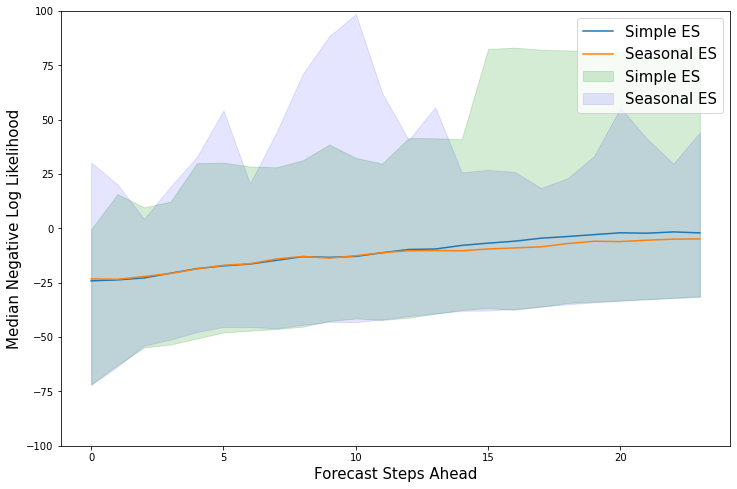

In [258]:
from functools import partial

NLPD_df.dropna(axis=1).plot(figsize=(12,8))

plt.fill_between(NLPD_df_upper.index,
        NLPD_df_upper['Simple ES'],
        NLPD_df_lower['Simple ES'],
        color="C2",
        alpha=0.2,
        label='Simple ES')

plt.fill_between(NLPD_df_upper.index,
        NLPD_df_upper['Seasonal ES'],
        NLPD_df_lower['Seasonal ES'],
        color="blue",
        alpha=0.1,
        label='Seasonal ES')
plt.xlabel('Forecast Steps Ahead', fontsize = 15)
plt.ylabel('Median Negative Log Likelihood', fontsize = 15)
plt.legend(fontsize = 15)

plt.ylim(-100,100)
plt.savefig('../figures/benchmark_nll.png', dpi=300, bbox_inches='tight')


(-100.0, 100.0)

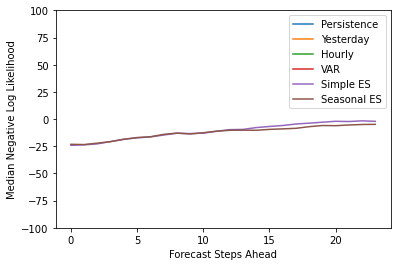

In [259]:
NLPD_df.plot()
plt.xlabel('Forecast Steps Ahead')
plt.ylabel('Median Negative Log Likelihood')
plt.ylim(-100,100)

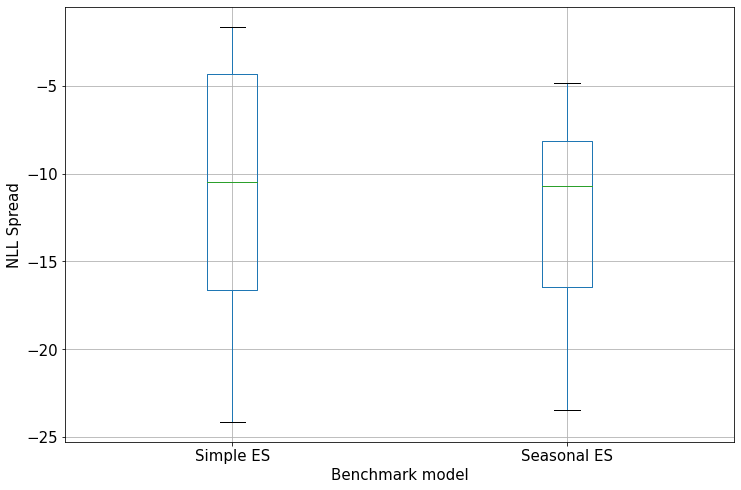

In [260]:
plt.figure(figsize=(12,8))
NLPD_df.iloc[:, -2:].boxplot(fontsize=15)
NLPD_df.median().dropna()
plt.xlabel('Benchmark model', fontsize=15)
plt.ylabel('NLL Spread', fontsize=15)
plt.savefig('../figures/benchmark_nll_spread.png', dpi=300, bbox_inches='tight')


# MAE

Persistence    0.130540
Yesterday      0.203255
Hourly         0.128039
VAR            0.168293
Simple ES      0.127407
Seasonal ES    0.129967
dtype: float64

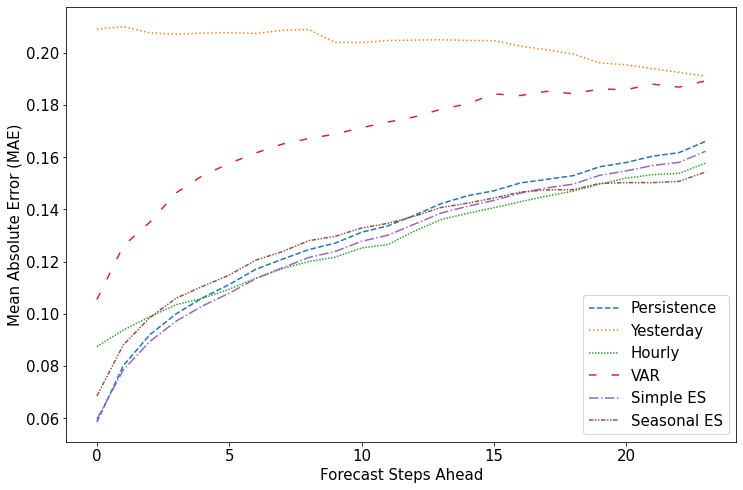

<Figure size 432x288 with 0 Axes>

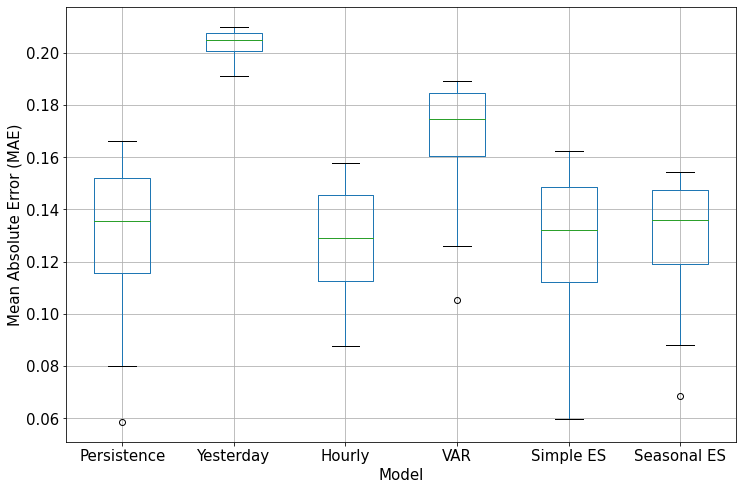

In [890]:
styles = ['--',':',(0, (1, 1)), (0, (5, 10)),'-.',(0, (3, 1, 1, 1, 1, 1))]
for col, st in zip(MAE_df.columns, styles):
    MAE_df[col].plot(figsize=(12,8), fontsize = 15, linestyle = st)
plt.xlabel('Forecast Steps Ahead', fontsize = 15)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=15)
plt.legend(fontsize = 15)
plt.savefig('../figures/benchmark_MAE.png', dpi=300, bbox_inches='tight')
plt.figure()


plt.figure(figsize=(12,8))
MAE_df.boxplot(fontsize = 15)
plt.xlabel('Model', fontsize = 15)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=15)
plt.savefig('../figures/benchmark_MAE_spread.png', dpi=300, bbox_inches='tight')

MAE_df.mean()

# FULL DISTRIBUTIONS OF ERRORS

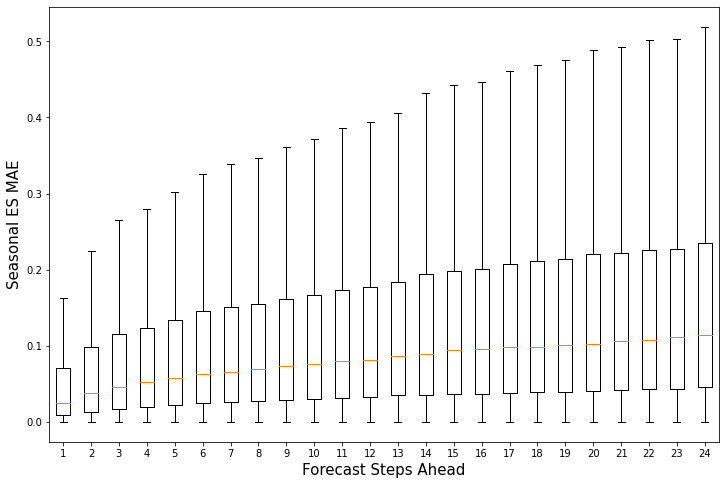

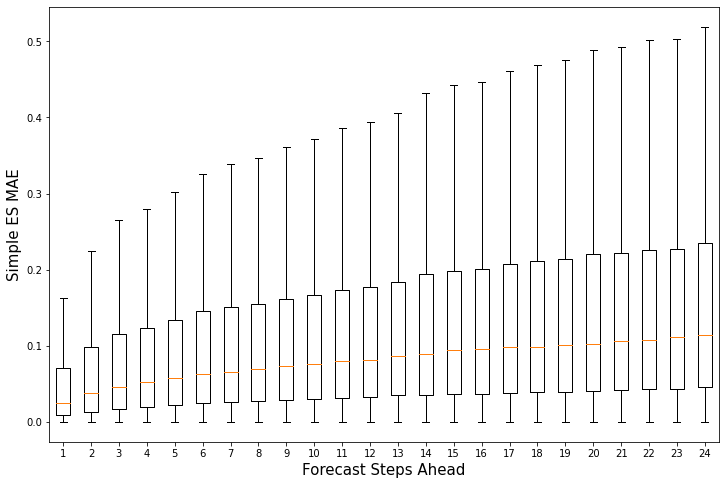

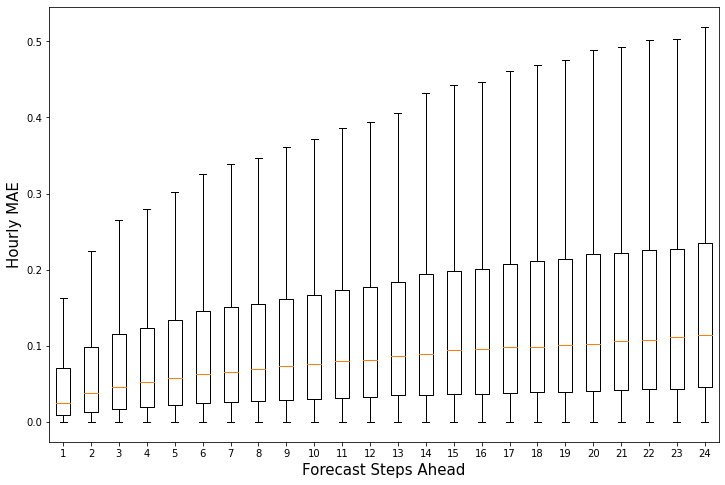

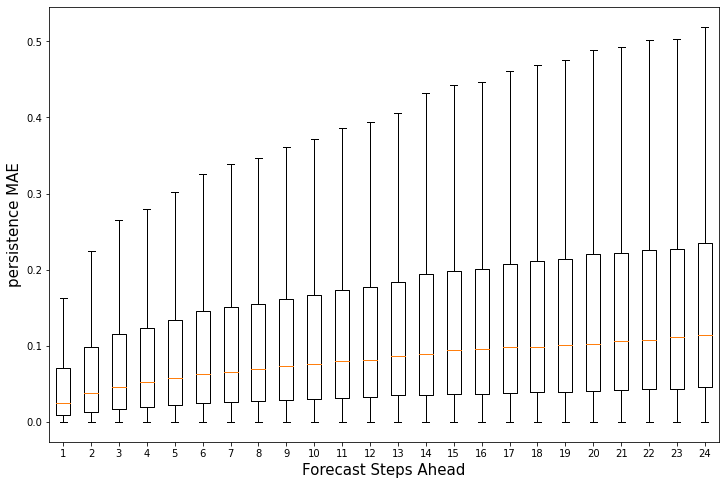

In [266]:
df_flattened = MAE_results_full['ExponentialSmoothing'].swapaxes(0, 1).reshape(24, -1)
med = np.quantile(df_flattened, 0.5, axis=1)
lower = np.quantile(df_flattened, 0.2, axis=1)
upper = np.quantile(df_flattened, 0.8, axis=1)
plt.figure( figsize=(12,8))
plt.boxplot(pers_flattened.T, showfliers=False);
plt.xlabel('Forecast Steps Ahead', fontsize=15)
plt.ylabel('Seasonal ES MAE', fontsize=15)
plt.savefig('../figures/seasonal_MAE_spread.png', dpi=300, bbox_inches='tight')
plt.show()


df_flattened = MAE_results_full['SimpleExpSmoothing'].swapaxes(0, 1).reshape(24, -1)
med = np.quantile(df_flattened, 0.5, axis=1)
lower = np.quantile(df_flattened, 0.2, axis=1)
upper = np.quantile(df_flattened, 0.8, axis=1)
plt.figure( figsize=(12,8))
plt.boxplot(pers_flattened.T, showfliers=False);
plt.xlabel('Forecast Steps Ahead', fontsize=15)
plt.ylabel('Simple ES MAE', fontsize=15)
plt.savefig('../figures/simple_MAE_spread.png', dpi=300, bbox_inches='tight')
plt.show()


df_flattened = MAE_results_full['hourly_average'].swapaxes(0, 1).reshape(24, -1)
med = np.quantile(df_flattened, 0.5, axis=1)
lower = np.quantile(df_flattened, 0.2, axis=1)
upper = np.quantile(df_flattened, 0.8, axis=1)
plt.figure( figsize=(12,8))
plt.boxplot(pers_flattened.T, showfliers=False);
plt.xlabel('Forecast Steps Ahead', fontsize=15)
plt.ylabel('Hourly MAE', fontsize=15)
plt.savefig('../figures/hourly_average_MAE_spread.png', dpi=300, bbox_inches='tight')
plt.show()

df_flattened = MAE_results_full['persistence'].swapaxes(0, 1).reshape(24, -1)
med = np.quantile(df_flattened, 0.5, axis=1)
lower = np.quantile(df_flattened, 0.2, axis=1)
upper = np.quantile(df_flattened, 0.8, axis=1)
plt.figure( figsize=(12,8))
plt.boxplot(pers_flattened.T, showfliers=False);
plt.xlabel('Forecast Steps Ahead', fontsize=15)
plt.ylabel('persistence MAE', fontsize=15)
plt.savefig('../figures/persistence_MAE_spread.png', dpi=300, bbox_inches='tight')
plt.show()

# GET RESULTS FROM GAUSSIAN PROCESS CV

## PERIODIC 7Z

In [610]:
# errors_1_GP = np.load('../output/Periodic_7z_ALL/CV_results_second_run_periodic_7z/partial_errors.npy')
# nnls_1_GP = np.load('../output/Periodic_7z_ALL/CV_results_second_run_periodic_7z/partial_NNLs.npy')

# errors_2_GP = np.load('../output/Periodic_7z_ALL/CV_results_second_run_periodic_7z_second_part/partial_errors.npy')
# nnls_2_GP = np.load('../output/Periodic_7z_ALL/CV_results_second_run_periodic_7z_second_part/partial_NNLs.npy')

# errors_3_GP = np.load('../output/Periodic_7z_ALL/CV_results_second_run_periodic_7z_third_part/partial_errors.npy')
# nnls_3_GP = np.load('../output/Periodic_7z_ALL/CV_results_second_run_periodic_7z_third_part/partial_NNLs.npy')

# errors_GP = np.concatenate((errors_2_GP[:, 1:], errors_3_GP[:, 1:], errors_1_GP[:, 1:]), axis=1)
# nlls_GP = np.concatenate((nnls_2_GP[:, 1:], nnls_3_GP[:, 1:], nnls_1_GP[:, 1:]), axis=1)

# np.save('../Good_outputs/Periodic_7z/errors_GP.npy', errors_GP)
# np.save('../Good_outputs/Periodic_7z/nlls_GP.npy', nlls_GP)

errors_GP = np.load('../Good_outputs/Periodic_7z/errors_GP.npy')
nlls_GP = np.load('../Good_outputs/Periodic_7z/nlls_GP.npy')


In [612]:
error_evolution_GP = errors_GP.mean(axis=0)
MAE_hsteps_GP = errors_GP.mean(axis=1)
NLLs_hsteps_GP = np.quantile(nlls_GP, 0.5, axis=1)
NLLs_hsteps_upper_GP = np.quantile(nlls_GP, 0.975, axis=1)
NLLs_hsteps_upper_GP[NLLs_hsteps_upper_GP==np.inf] = 150
NLLs_hsteps_lower_GP = np.quantile(nlls_GP, 0.025, axis=1)

NLPD_df_GP = pd.DataFrame.from_dict(NLLs_hsteps_GP).rename(columns={0:'Gaussian Process'})
NLPD_df_upper_GP = pd.DataFrame.from_dict(NLLs_hsteps_upper_GP).rename(columns={0:'Gaussian Process'})
NLPD_df_lower_GP = pd.DataFrame.from_dict(NLLs_hsteps_lower_GP).rename(columns={0:'Gaussian Process'})

## PERIODIC 21z

In [902]:
# errors_1_GP_21 = np.load('../output/first_run_periodic_21z/partial_errors.npy')
# nnls_1_GP_21 = np.load('../output/first_run_periodic_21z/partial_NNLs.npy')

# errors_2_GP_21 = np.load('../output/second_run_periodic_21z/partial_errors.npy')
# nnls_2_GP_21 = np.load('../output/second_run_periodic_21z/partial_NNLs.npy')

# errors_GP_21 = np.concatenate((errors_1_GP_21[:, 1:], errors_2_GP_21[:, 1:]), axis=1)
# nnls_GP_21 = np.concatenate((nnls_1_GP_21[:, 1:], nnls_2_GP_21[:, 1:]), axis=1)

# np.save('../Good_outputs/Periodic_21z/errors_GP.npy', errors_GP_21)
# np.save('../Good_outputs/Periodic_21z/nlls_GP.npy', nnls_GP_21)

errors_GP_21 = np.load('../Good_outputs/Periodic_21z/errors_GP.npy')
nlls_GP_21 = np.load('../Good_outputs/Periodic_21z/nlls_GP.npy')


In [905]:
error_evolution_GP_21 = errors_GP_21.mean(axis=0)
MAE_hsteps_GP_21 = errors_GP_21.mean(axis=1)
NLLs_hsteps_GP_21 = np.quantile(nlls_GP_21, 0.5, axis=1)
NLLs_hsteps_upper_GP_21 = np.quantile(nlls_GP_21, 0.975, axis=1)
NLLs_hsteps_upper_GP_21[NLLs_hsteps_upper_GP_21==np.inf] = 150
NLLs_hsteps_upper_GP_21 = np.array(pd.Series(NLLs_hsteps_upper_GP_21).interpolate().tolist())
NLLs_hsteps_lower_GP_21 = np.quantile(nlls_GP_21, 0.025, axis=1)

In [909]:
NLPD_df_GP_21 = pd.DataFrame.from_dict(NLLs_hsteps_GP_21).rename(columns={0:'Gaussian Process'})
NLPD_df_upper_GP_21 = pd.DataFrame.from_dict(NLLs_hsteps_upper_GP_21).rename(columns={0:'Gaussian Process'})
NLPD_df_lower_GP_21 = pd.DataFrame.from_dict(NLLs_hsteps_lower_GP_21).rename(columns={0:'Gaussian Process'})

## Simple 7z

In [689]:
errors_GP_simple_7 = np.load('../Good_outputs/simple_7z/partial_errors.npy')[: ,1:]
nlls_GP_simple_7 = np.load('../Good_outputs/simple_7z/partial_NNLs.npy')[: ,1:]


In [690]:
error_evolution_simple_7 = errors_GP_simple_7.mean(axis=0)
MAE_hsteps_simple_7 = errors_GP_simple_7.mean(axis=1)
NLLs_hsteps_simple_7 = np.quantile(nlls_GP_simple_7, 0.5, axis=1)
NLLs_hsteps_upper_simple_7 = np.quantile(nlls_GP_simple_7, 0.975, axis=1)
# NLLs_hsteps_upper_GP_21[NLLs_hsteps_upper_GP_21==np.inf] = 150
# NLLs_hsteps_upper_GP_21 = np.array(pd.Series(NLLs_hsteps_upper_GP_21).interpolate().tolist())
NLLs_hsteps_lower_simple_7 = np.quantile(nlls_GP_simple_7, 0.025, axis=1)

Text(0, 0.5, 'Median Negative Log Likelihood')

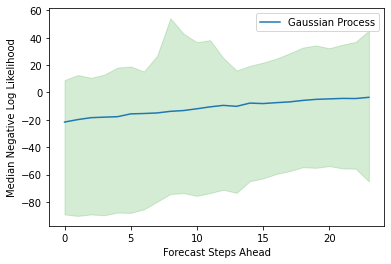

In [693]:
NLPD_df_simple_7 = pd.DataFrame.from_dict(NLLs_hsteps_simple_7).rename(columns={0:'Gaussian Process'})
NLPD_df_upper_simple_7 = pd.DataFrame.from_dict(NLLs_hsteps_upper_simple_7).rename(columns={0:'Gaussian Process'})
NLPD_df_lower_simple_7 = pd.DataFrame.from_dict(NLLs_hsteps_lower_simple_7).rename(columns={0:'Gaussian Process'})

## Simple 21z

In [906]:
# errors_1_simple_21 = np.load('../Good_outputs/run_simple_21z/partial_errors.npy')
# nnls_1_simple_21 = np.load('../Good_outputs/run_simple_21z/partial_NNLs.npy')

# errors_2_simple_21 = np.load('../Good_outputs/run_simple_21z_part2/partial_errors.npy')
# nnls_2_simple_21 = np.load('../Good_outputs/run_simple_21z_part2/partial_NNLs.npy')

# errors_3_simple_21 = np.load('../Good_outputs/run_simple_21z_part3/partial_errors.npy')
# nnls_3_simple_21 = np.load('../Good_outputs/run_simple_21z_part3/partial_NNLs.npy')

# errors_simple_21 = np.concatenate((errors_1_simple_21[:, 1:], errors_2_simple_21[:, 1:], errors_3_simple_21[:, 1:]), axis=1)
# nnls_simple_21 = np.concatenate((nnls_1_simple_21[:, 1:], nnls_2_simple_21[:, 1:], nnls_3_simple_21[:, 1:]), axis=1)

# np.save('../Good_outputs/simple_21z/errors_GP.npy', errors_simple_21)
# np.save('../Good_outputs/simple_21z/nlls_GP.npy', nnls_simple_21)

errors_simple_21 = np.load('../Good_outputs/simple_21z/errors_GP.npy')
nlls_simple_21 = np.load('../Good_outputs/simple_21z/nlls_GP.npy')

In [907]:
error_evolution_simple_21 = errors_simple_21.mean(axis=0)
MAE_hsteps_simple_21 = errors_simple_21.mean(axis=1)
NLLs_hsteps_simple_21 = np.quantile(nlls_simple_21, 0.5, axis=1)
NLLs_hsteps_upper_simple_21 = np.quantile(nlls_simple_21, 0.975, axis=1)
# NLLs_hsteps_upper_GP_21[NLLs_hsteps_upper_GP_21==np.inf] = 150
# NLLs_hsteps_upper_GP_21 = np.array(pd.Series(NLLs_hsteps_upper_GP_21).interpolate().tolist())
NLLs_hsteps_lower_simple_21 = np.quantile(nlls_simple_21, 0.025, axis=1)

In [908]:
NLPD_df_simple_21 = pd.DataFrame.from_dict(NLLs_hsteps_simple_21).rename(columns={0:'Gaussian Process'})
NLPD_df_upper_simple_21 = pd.DataFrame.from_dict(NLLs_hsteps_upper_simple_21).rename(columns={0:'Gaussian Process'})
NLPD_df_lower_simple_21 = pd.DataFrame.from_dict(NLLs_hsteps_lower_simple_21).rename(columns={0:'Gaussian Process'})

## Comparing all ST GP models

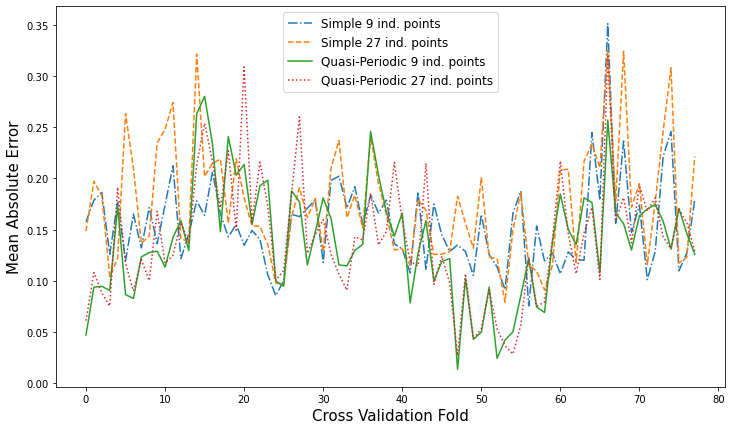

In [919]:
plt.figure(figsize=(12,7))
plt.plot(error_evolution_simple_7, label = 'Simple 9 ind. points',linestyle='-.')
plt.plot(error_evolution_simple_21, label = 'Simple 27 ind. points',linestyle='--')
plt.plot(error_evolution_GP, label = 'Quasi-Periodic 9 ind. points',linestyle='-')
plt.plot(error_evolution_GP_21, label = 'Quasi-Periodic 27 ind. points',linestyle=':')
plt.xlabel('Cross Validation Fold',fontsize = 15)
plt.ylabel('Mean Absolute Error',fontsize = 15)
plt.legend(fontsize = 12) 
# plt.savefig('../figures/mae_vs_cv_fold.png', dpi=300, bbox_inches='tight')

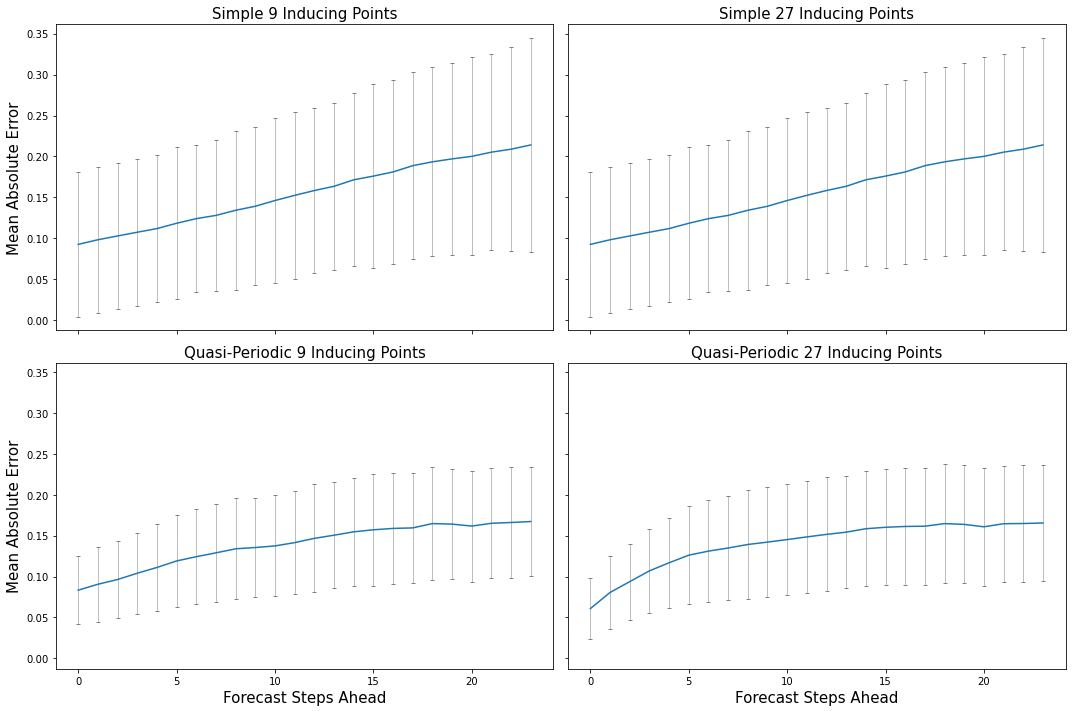

In [920]:
fig, ax = plt.subplots(2,2, figsize=(15,10), sharex = True, sharey = True)
ax[1,0].errorbar(range(len(MAE_hsteps_GP)), MAE_hsteps_GP, errors_GP.std(axis=1), ecolor = 'grey', 
             elinewidth = 0.5, capsize=2, linestyle='-')
ax[1,1].errorbar(range(len(MAE_hsteps_GP_21)), MAE_hsteps_GP_21, errors_GP_21.std(axis=1), ecolor = 'grey', 
             elinewidth = 0.5, capsize=2  ,linestyle='-')
ax[0,0].errorbar(range(len(MAE_hsteps_simple_7)), MAE_hsteps_simple_7, 2 * errors_GP_simple_7.std(axis=1), ecolor = 'grey', 
             elinewidth = 0.5, capsize=2 , linestyle='-')
ax[0,1].errorbar(range(len(MAE_hsteps_simple_21)), MAE_hsteps_simple_7, 2 * errors_GP_simple_7.std(axis=1), ecolor = 'grey', 
             elinewidth = 0.5, capsize=2 , linestyle='-')

ax[0,0].set_ylabel('Mean Absolute Error', fontsize = 15)
ax[1,0].set_title('Quasi-Periodic 9 Inducing Points', fontsize = 15)
ax[1,1].set_title('Quasi-Periodic 27 Inducing Points', fontsize = 15)
ax[1,0].set_xlabel('Forecast Steps Ahead', fontsize = 15)
ax[1,0].set_ylabel('Mean Absolute Error', fontsize = 15)
ax[0,0].set_title('Simple 9 Inducing Points', fontsize = 15)
ax[1,1].set_xlabel('Forecast Steps Ahead', fontsize = 15)
ax[0,1].set_title('Simple 27 Inducing Points', fontsize = 15)

plt.tight_layout()
# plt.savefig('../figures/four_gps_MAE.png', dpi=300, bbox_inches='tight')


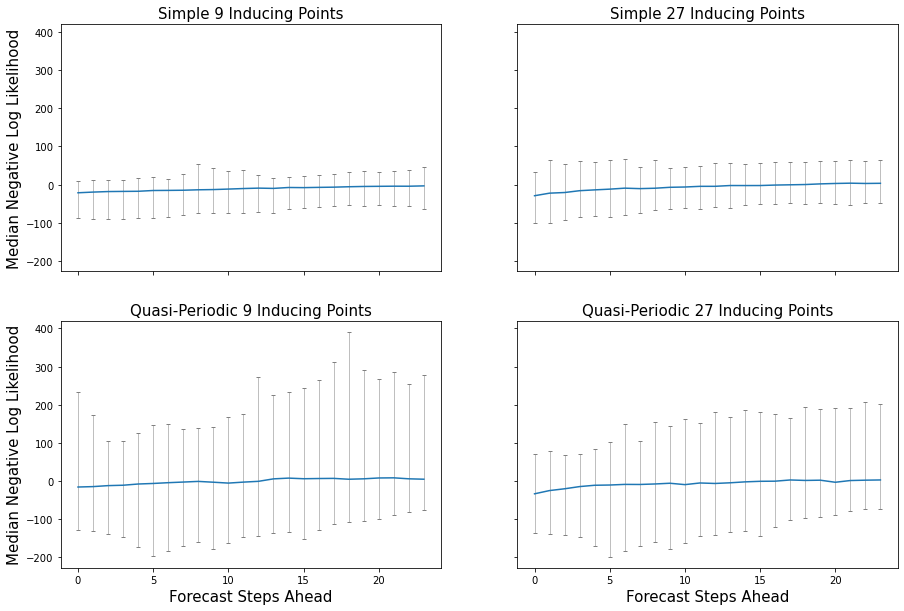

In [921]:
fig, ax = plt.subplots(2,2, figsize=(15,10), sharex = True, sharey = True)

ax[1,0].errorbar(range(len(NLPD_df_GP)), NLPD_df_GP.values[:, 0], 
            np.array([(NLPD_df_GP-NLPD_df_lower_GP).values[:,0],
                      (NLPD_df_upper_GP-NLPD_df_GP).values[:,0]]),
                 ecolor = 'grey', elinewidth = 0.5, capsize=2 , linestyle='-')

ax[1,1].errorbar(range(len(NLPD_df_GP_21)), NLPD_df_GP_21.values[:, 0], 
            np.array([(NLPD_df_GP_21-NLPD_df_lower_GP_21).values[:,0],
                      (NLPD_df_upper_GP_21-NLPD_df_GP_21).values[:,0]]),
                 ecolor = 'grey', elinewidth = 0.5, capsize=2 , linestyle='-')

ax[0, 0].errorbar(range(len(NLPD_df_simple_7)), NLPD_df_simple_7.values[:, 0], 
            np.array([(NLPD_df_simple_7-NLPD_df_lower_simple_7).values[:,0],
                      (NLPD_df_upper_simple_7-NLPD_df_simple_7).values[:,0]]),
                 ecolor = 'grey', elinewidth = 0.5, capsize=2 , linestyle='-')

ax[0,1].errorbar(range(len(NLPD_df_simple_21)), NLPD_df_simple_21.values[:, 0], 
            np.array([(NLPD_df_simple_21-NLPD_df_lower_simple_21).values[:,0],
                      (NLPD_df_upper_simple_21-NLPD_df_simple_21).values[:,0]]),
                 ecolor = 'grey', elinewidth = 0.5, capsize=2 , linestyle='-')

ax[0,0].set_ylabel('Median Negative Log Likelihood', fontsize = 15)
ax[1,0].set_title('Quasi-Periodic 9 Inducing Points', fontsize = 15)
ax[1,1].set_title('Quasi-Periodic 27 Inducing Points', fontsize = 15)
ax[1,0].set_xlabel('Forecast Steps Ahead', fontsize = 15)
ax[1,0].set_ylabel('Median Negative Log Likelihood', fontsize = 15)
ax[0,0].set_title('Simple 9 Inducing Points', fontsize = 15)
ax[1,1].set_xlabel('Forecast Steps Ahead', fontsize = 15)
ax[0,1].set_title('Simple 27 Inducing Points', fontsize = 15)

# plt.savefig('../figures/four_gps_NLL.png', dpi=300, bbox_inches='tight')

# plt.tight_layout()

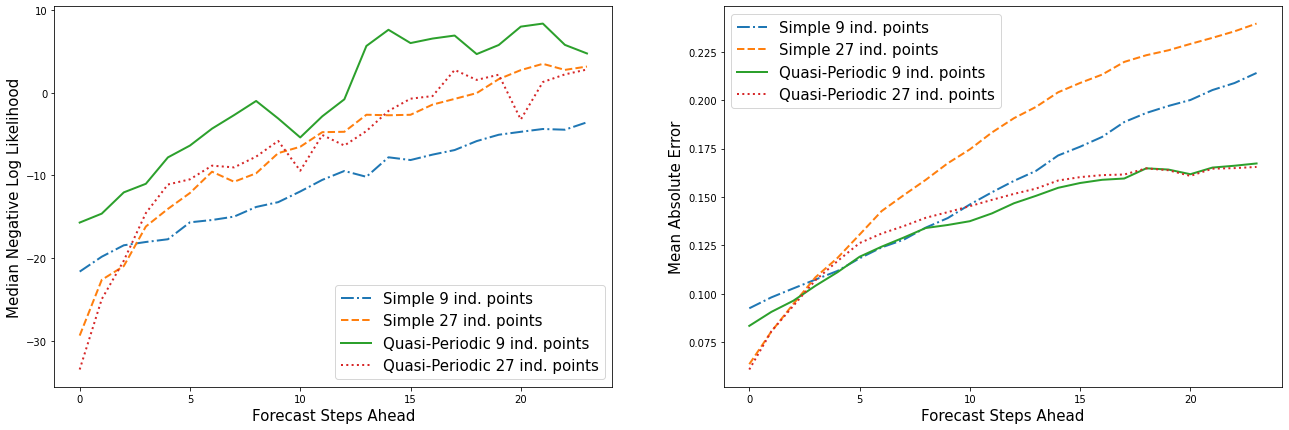

In [922]:
fig, ax = plt.subplots(1,2, figsize=(22,7))
ax[0].plot(NLPD_df_simple_7, label = 'Simple 9 ind. points',linestyle='-.', linewidth=2)
ax[0].plot(NLPD_df_simple_21, label = 'Simple 27 ind. points',linestyle='--', linewidth=2)
ax[0].plot(NLPD_df_GP, label = 'Quasi-Periodic 9 ind. points',linestyle='-', linewidth=2)
ax[0].plot(NLPD_df_GP_21, label = 'Quasi-Periodic 27 ind. points',linestyle=':', linewidth=2)

ax[0].set_xlabel('Forecast Steps Ahead',fontsize = 15)
ax[0].set_ylabel('Median Negative Log Likelihood',fontsize = 15);
ax[0].legend(fontsize = 15) 

ax[1].plot(MAE_hsteps_simple_7, label = 'Simple 9 ind. points',linestyle='-.', linewidth=2)
ax[1].plot(MAE_hsteps_simple_21, label = 'Simple 27 ind. points',linestyle='--', linewidth=2)
ax[1].plot(MAE_hsteps_GP, label = 'Quasi-Periodic 9 ind. points',linestyle='-', linewidth=2)
ax[1].plot(MAE_hsteps_GP_21, label = 'Quasi-Periodic 27 ind. points',linestyle=':', linewidth=2)

ax[1].set_xlabel('Forecast Steps Ahead',fontsize = 15)
ax[1].set_ylabel('Mean Absolute Error',fontsize = 15);
ax[1].legend(fontsize = 15) 
# plt.tight_layout()

# plt.savefig('../figures/compare_four_GPs_overlap.png', dpi=300, bbox_inches='tight')




In [923]:
print(f'The MAE for Simple 9z is {MAE_hsteps_simple_7.mean()}')
print(f'The MAE for Simple 27z is {MAE_hsteps_simple_21.mean()}')
print(f'The MAE for Periodic 9z is {MAE_hsteps_GP.mean()}')
print(f'The MAE for Periodic 27z is {MAE_hsteps_GP_21.mean()}')

print(f'The NLL for Simple 9z is {NLPD_df_simple_7.mean()}')
print(f'The NLL for Simple 27z is {NLPD_df_simple_21.mean()}')
print(f'The NLL for Periodic 9z is {NLPD_df_GP.mean()}')
print(f'The NLL for Periodic 27z is {NLPD_df_GP_21.mean()}')

The MAE for Simple 9z is 0.15465219779872671
The MAE for Simple 27z is 0.17467788458732725
The MAE for Periodic 9z is 0.13847214407481742
The MAE for Periodic 27z is 0.1399262315362236
The NLL for Simple 9z is Gaussian Process   -11.221606
dtype: float64
The NLL for Simple 27z is Gaussian Process   -6.875516
dtype: float64
The NLL for Periodic 9z is Gaussian Process   -0.723605
dtype: float64
The NLL for Periodic 27z is Gaussian Process   -6.893259
dtype: float64


## Plotting Results of GPs vs Benchmarks

Text(0, 0.5, 'Median Negative Log Likelihood')

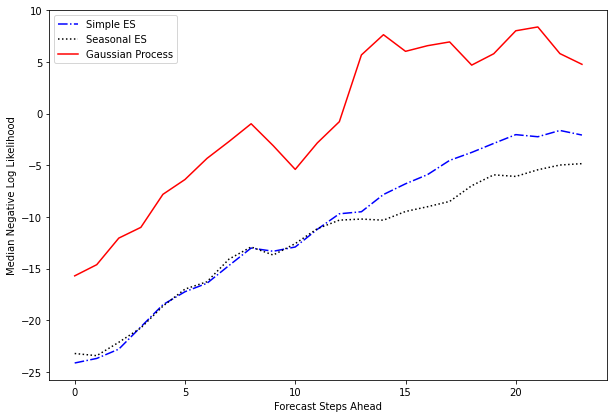

In [573]:
likelihoods_df = pd.concat([NLPD_df,NLPD_df_GP ], axis=1).iloc[:, -3:]
likelihoods_df_upper = pd.concat([NLPD_df_upper,NLPD_df_upper_GP ], axis=1).iloc[:, -3:]
likelihoods_df_lower = pd.concat([NLPD_df_lower,NLPD_df_lower_GP ], axis=1).iloc[:, -3:]

styles = ['-.', ':', '-']
colors = ['blue', 'black', 'red']

fig, ax = plt.subplots(figsize=(10,6.8))
for col, style, c in zip(likelihoods_df.columns, styles, colors):
    likelihoods_df[col].plot(linestyle=style,  ax=ax, color = c)
#     plt.fill_between(likelihoods_df[col].index,
#         likelihoods_df_upper[col],
#         likelihoods_df_lower[col],
#         color="C2",
#         alpha=0.2)
    
# plt.ylim(-300, 200)
    
plt.legend()
plt.xlabel('Forecast Steps Ahead')
plt.ylabel('Median Negative Log Likelihood')


Text(0, 0.5, 'Mean Absolute Error')

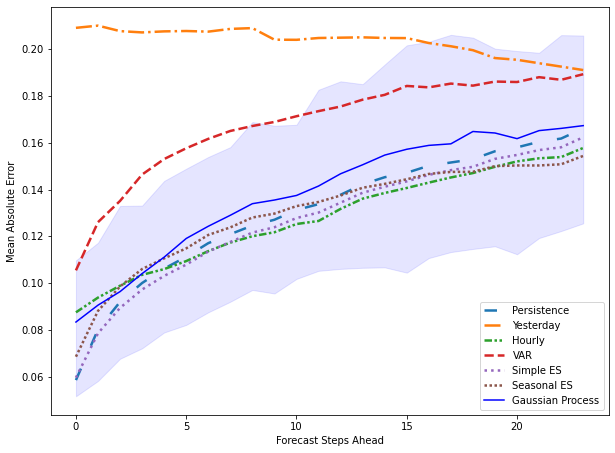

In [574]:
# errors_df = pd.concat([ MAE_df_std, pd.Series(errors_GP.std(axis=1), name='Gaussian Process')], axis=1)

styles = [(0, (5, 10)),'-.',(0, (3, 1, 1, 1, 1, 1)), '--',':',(0, (1, 1))]

fig, ax = plt.subplots(figsize=(10, 7.5))
for col, style in zip(MAE_df.columns, styles):
    MAE_df[col].plot(linestyle=style,  ax=ax, linewidth = 2.5)
    if col == 'ExponentialSmoothing':
        ax.fill_between(MAE_df[col].index,
            upper_error_benchmark[col],
            lower_error_benchmark[col],
            alpha=0.1, color = 'brown')
    
ax.plot(MAE_hsteps_GP, label='Gaussian Process', linestyle='-', color = 'b')
ax.fill_between(MAE_df[col].index,
        np.quantile(errors_GP, 0.25, axis=1),
        np.quantile(errors_GP, 0.75, axis=1),
        alpha=0.1, color = 'b')

plt.legend()
plt.xlabel('Forecast Steps Ahead')
plt.ylabel('Mean Absolute Error')


In [575]:
MAE_df.mean(axis=0)

Persistence    0.130540
Yesterday      0.203255
Hourly         0.128039
VAR            0.168293
Simple ES      0.127407
Seasonal ES    0.129967
dtype: float64

##Â Plotting SimpleExpSmoothing Preds

PLOTTING SYSTEM 0


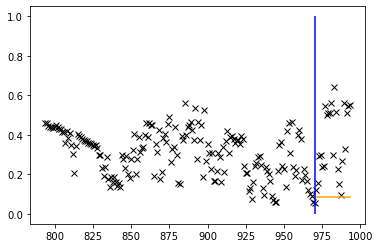

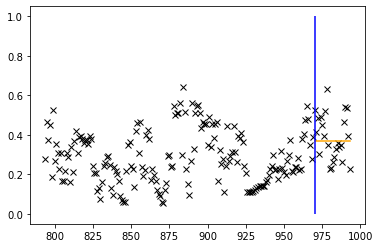

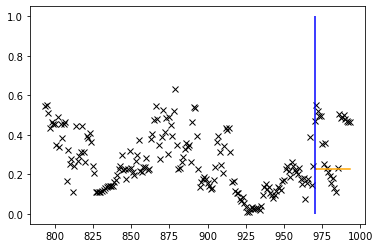

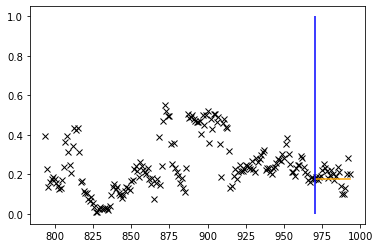

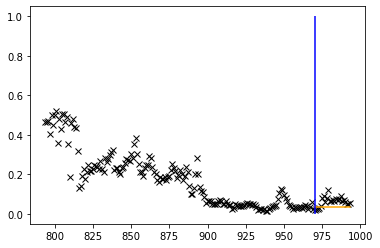

PLOTTING SYSTEM 1


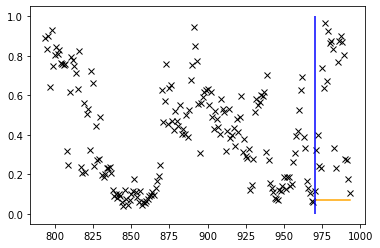

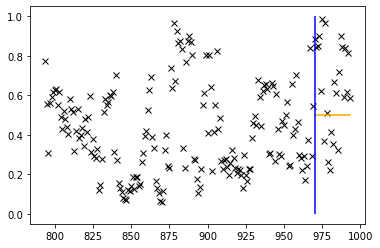

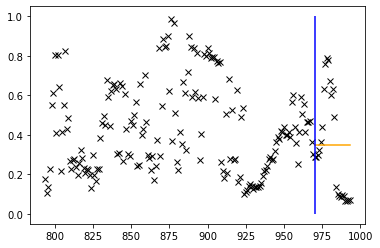

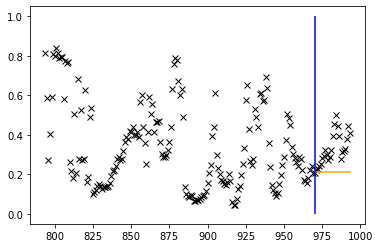

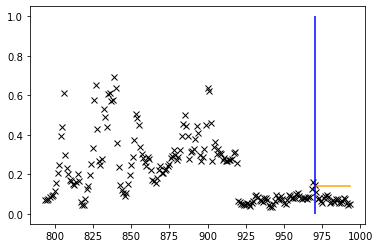

PLOTTING SYSTEM 2


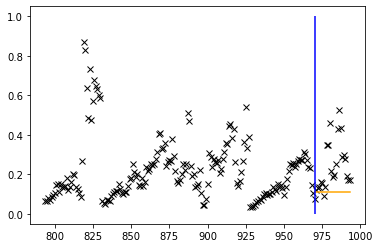

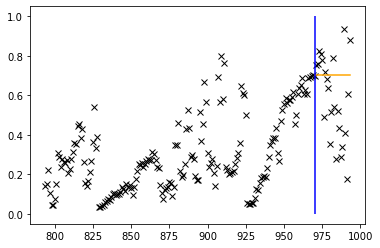

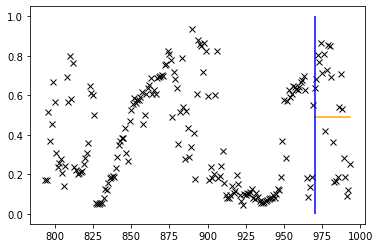

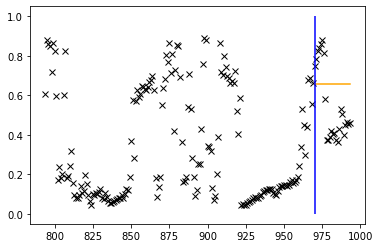

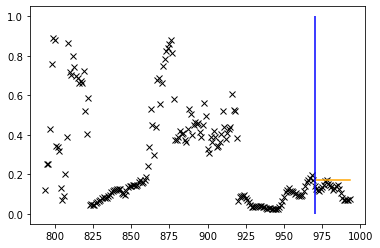

PLOTTING SYSTEM 3


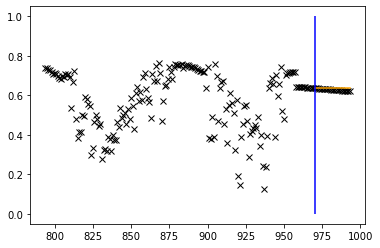

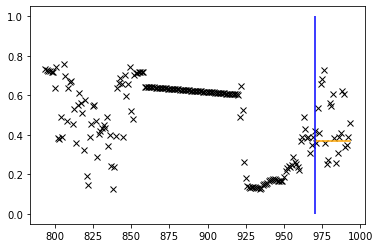

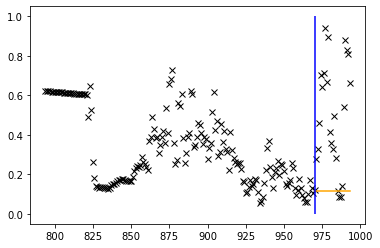

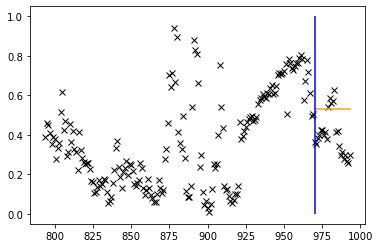

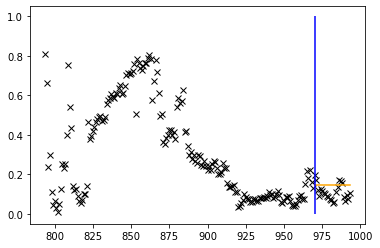

PLOTTING SYSTEM 4


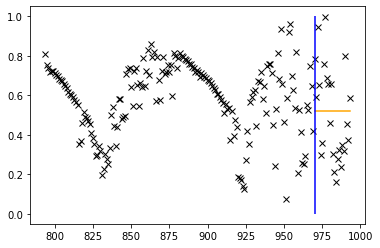

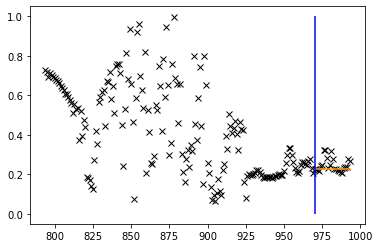

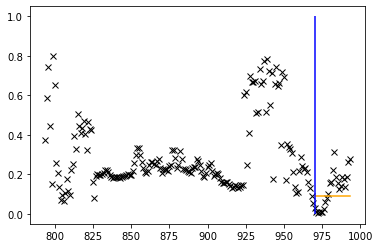

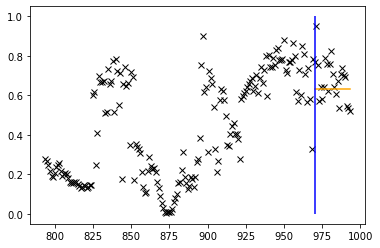

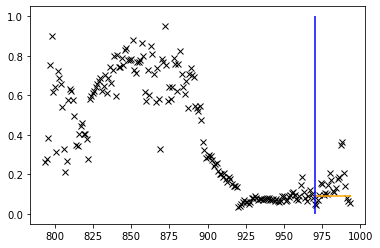

In [213]:
model_type = 'SimpleExpSmoothing'
for ts in range(n_sys_VAR)[:5]:
    print(f'PLOTTING SYSTEM {ts}')
    for i, t in enumerate(range_idx[:5]):
        data_multiple_iter = data_multiple.iloc[t:t+length_window + 24]
        data_multiple_train = data_multiple_iter.iloc[:length_window] 
        data_multiple_test = data_multiple_iter[length_window:]  

        plt.plot(data_multiple_iter.reset_index().index[-200:], data_multiple_iter.iloc[:, ts][-200:],  "xk")
        plt.plot(data_multiple_iter.reset_index().index[-24:], predictions_results[model_type][i, :, ts], color = 'orange')
        plt.vlines(data_multiple_iter.reset_index().index[-24], 0, 1, colors='blue')

        plt.show()

PLOTTING SYSTEM 0


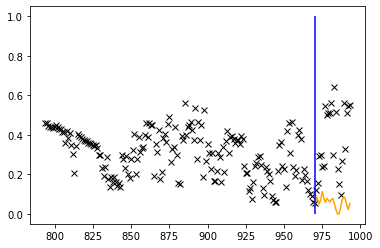

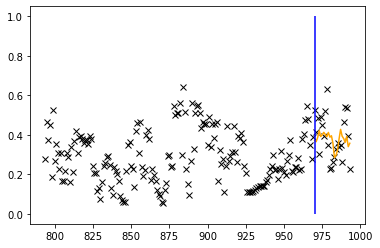

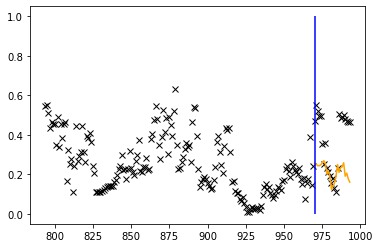

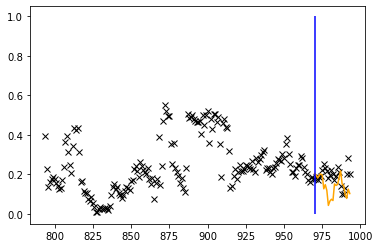

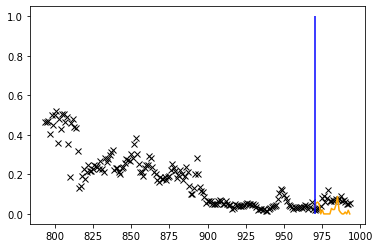

PLOTTING SYSTEM 1


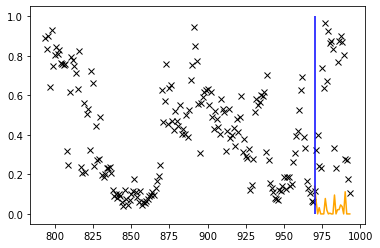

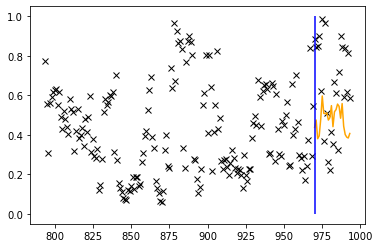

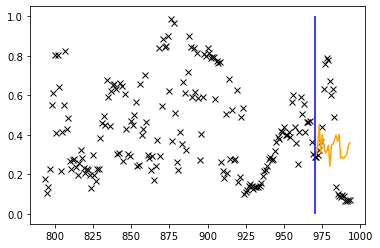

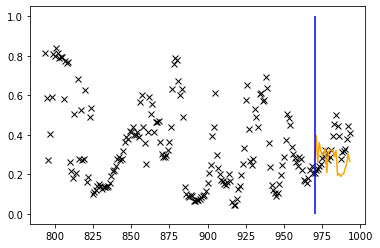

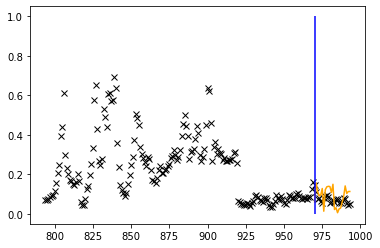

PLOTTING SYSTEM 2


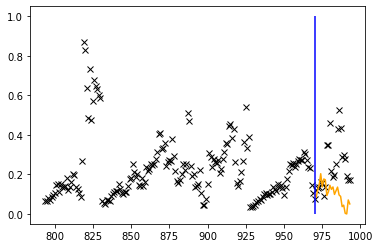

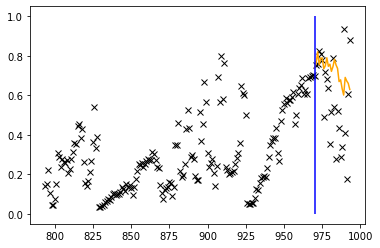

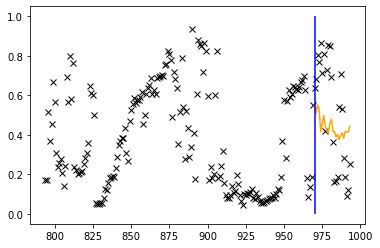

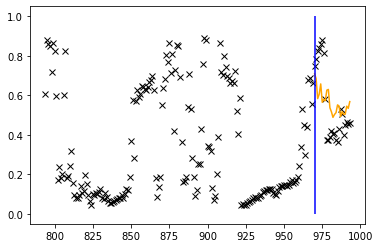

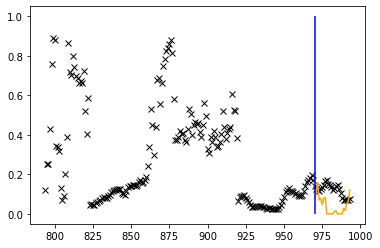

PLOTTING SYSTEM 3


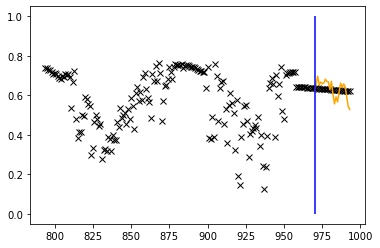

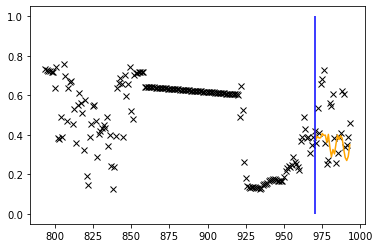

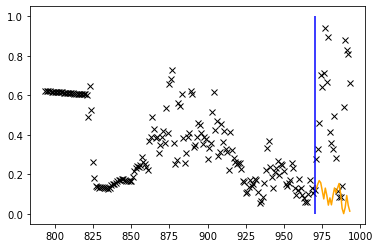

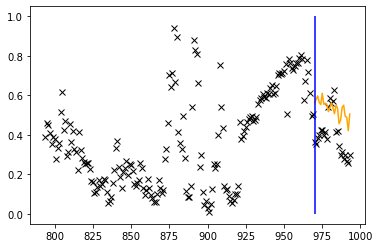

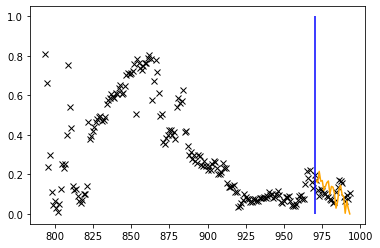

PLOTTING SYSTEM 4


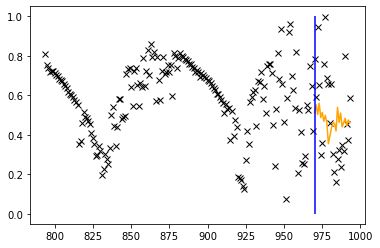

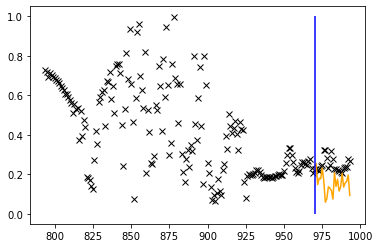

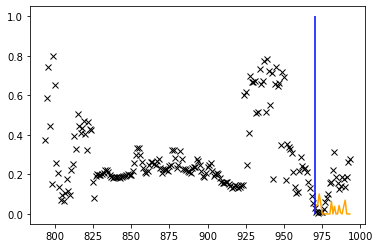

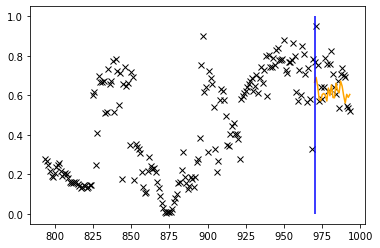

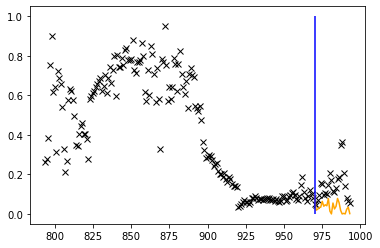

In [214]:
model_type = 'ExponentialSmoothing'
for ts in range(n_sys_VAR)[:5]:
    print(f'PLOTTING SYSTEM {ts}')
    for i, t in enumerate(range_idx[:5]):
        data_multiple_iter = data_multiple.iloc[t:t+length_window + 24]
        data_multiple_train = data_multiple_iter.iloc[:length_window] 
        data_multiple_test = data_multiple_iter[length_window:]  

        plt.plot(data_multiple_iter.reset_index().index[-200:], data_multiple_iter.iloc[:, ts][-200:],  "xk")
        plt.plot(data_multiple_iter.reset_index().index[-24:], predictions_results[model_type][i, :, ts], color = 'orange')
        plt.vlines(data_multiple_iter.reset_index().index[-24], 0, 1, colors='blue')

        plt.show()

PLOTTING SYSTEM 0


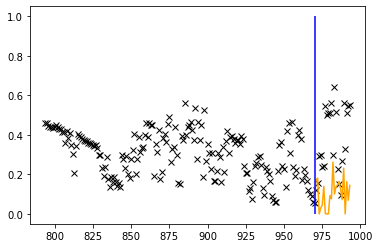

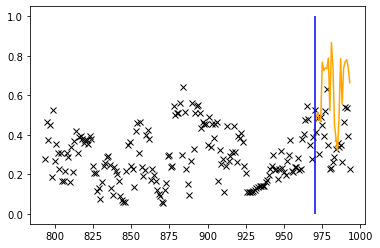

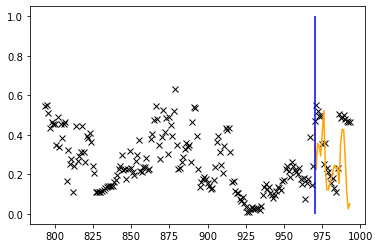

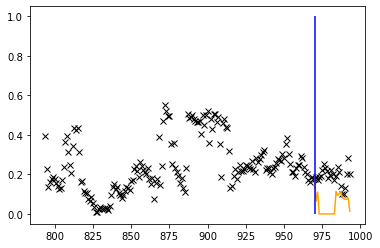

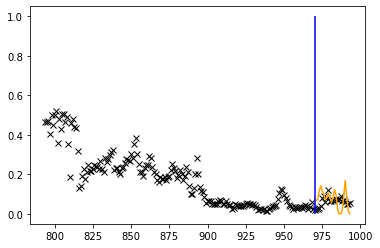

PLOTTING SYSTEM 1


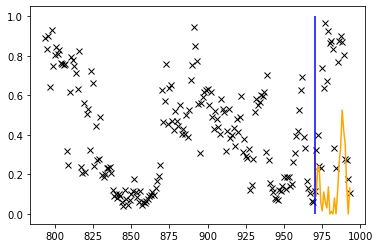

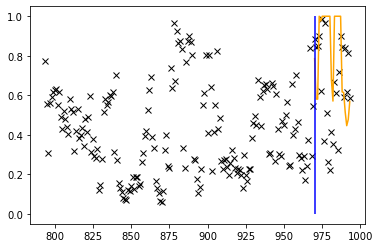

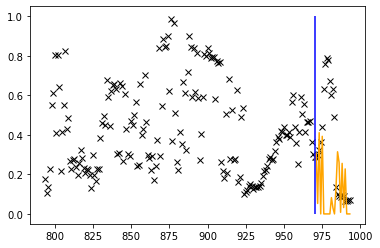

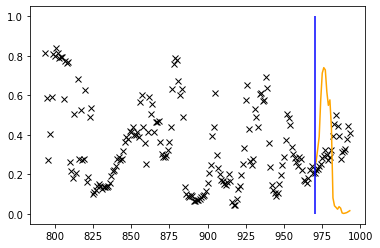

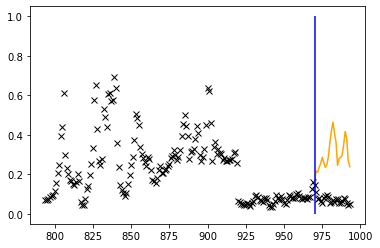

PLOTTING SYSTEM 2


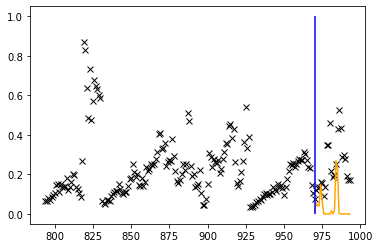

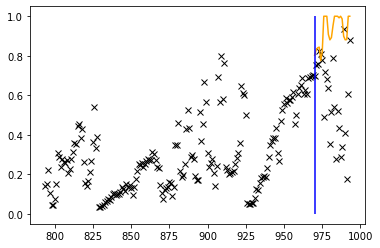

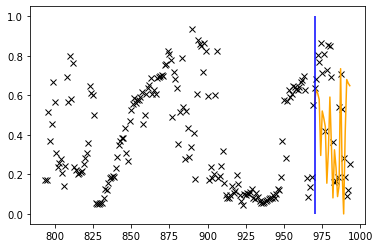

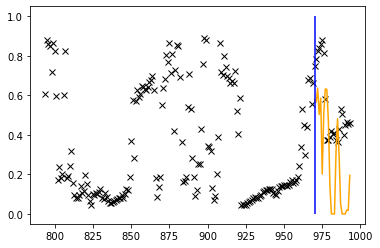

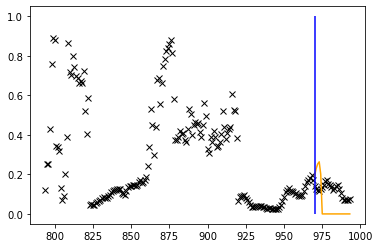

PLOTTING SYSTEM 3


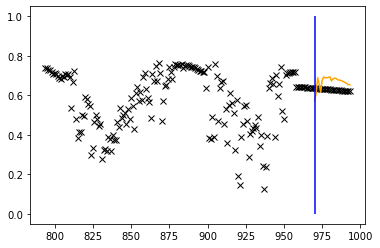

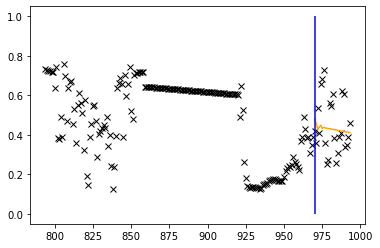

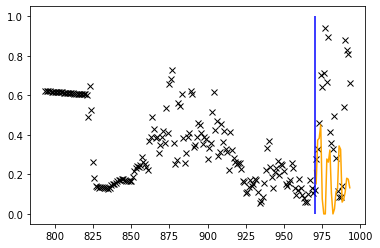

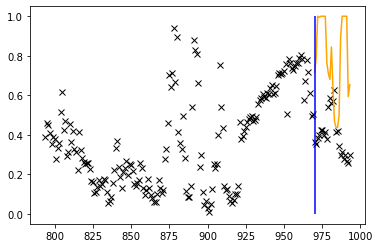

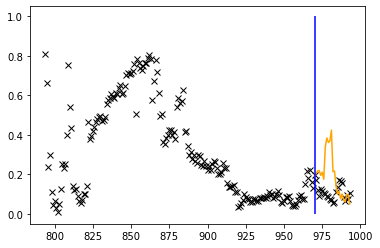

PLOTTING SYSTEM 4


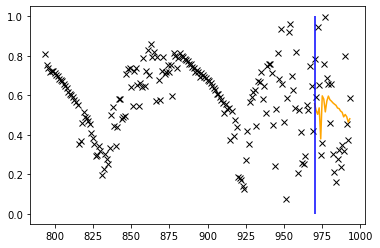

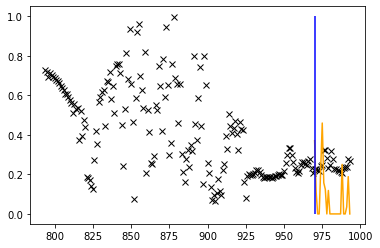

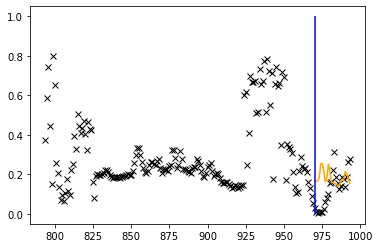

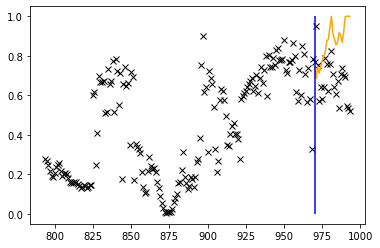

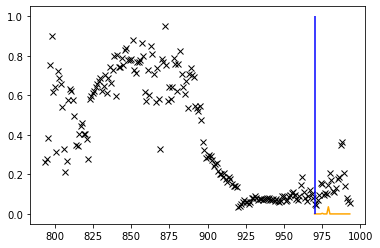

In [216]:
model_type = 'VAR'
for ts in range(n_sys_VAR)[:5]:
    print(f'PLOTTING SYSTEM {ts}')
    for i, t in enumerate(range_idx[:5]):
        data_multiple_iter = data_multiple.iloc[t:t+length_window + 24]
        data_multiple_train = data_multiple_iter.iloc[:length_window] 
        data_multiple_test = data_multiple_iter[length_window:]  

        plt.plot(data_multiple_iter.reset_index().index[-200:], data_multiple_iter.iloc[:, ts][-200:],  "xk")
        plt.plot(data_multiple_iter.reset_index().index[-24:], predictions_results[model_type][i, :, ts], color = 'orange')
        plt.vlines(data_multiple_iter.reset_index().index[-24], 0, 1, colors='blue')

        plt.show()

# Temporal-Only Benchmark Analysis: SIMPLE KERNEL

In [380]:
path = '../output/CV_results_independent_simple/'

# errors_simple = pd.read_csv(path+'errors.csv').iloc[:, 1:]
# NNLs = - pd.read_csv(path+'NNLs.csv').iloc[:, 1:]

NNLs[NNLs==np.inf] = np.nan
NNLs[NNLs==-np.inf] = np.nan

with open(path+'lower_predictions.csv', 'rb') as f:
    lower_predictions = pickle.load(f)
    
with open(path+'upper_predictions.csv', 'rb') as f:
    upper_predictions = pickle.load(f)
    
with open(path+'predictions.csv', 'rb') as f:
    predictions = pickle.load(f)


In [381]:
error_evolution_GP_ind_simple = errors_simple.mean(axis=0)
MAE_hsteps_GP_ind_simple = errors_simple.mean(axis=1)
NNLs_hsteps_GP_ind_simple = np.nanquantile(NNLs, 0.5, axis=1)
NNLs_hsteps_upper_G_ind_simpleP = np.nanquantile(NNLs, 0.975, axis=1)
NNLs_hsteps_lower_GP_ind_simple = np.nanquantile(NNLs, 0.025, axis=1)

Text(0, 0.5, 'Mean Absolute Error')

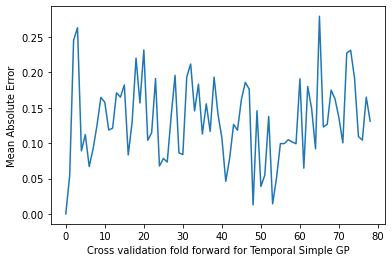

In [382]:
plt.plot(error_evolution_GP_ind_simple.values)
plt.xlabel('Cross validation fold forward for Temporal Simple GP')
plt.ylabel('Mean Absolute Error')

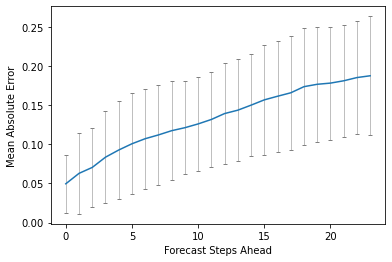

In [383]:
# plt.plot(MAE_hsteps_GP)
plt.errorbar(range(len(MAE_hsteps_GP_ind_simple)), MAE_hsteps_GP_ind_simple, errors_simple.std(axis=1), ecolor = 'grey', 
             elinewidth = 0.5, capsize=2, )
plt.xlabel('Forecast Steps Ahead')
plt.ylabel('Mean Absolute Error');

Text(0, 0.5, 'Median Negative Log Likelihood')

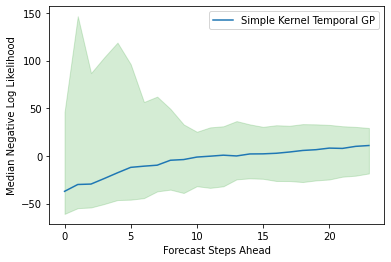

In [384]:
NLPD_df_GP_ind_simple = pd.DataFrame.from_dict(NNLs_hsteps_GP_ind_simple).rename(columns={0:'Simple Kernel Temporal GP'})
NLPD_df_upper_GP_ind_simple = pd.DataFrame.from_dict(NNLs_hsteps_upper_G_ind_simpleP).rename(columns={0:'Simple Kernel Temporal GP'})
NLPD_df_lower_GP_ind_simple = pd.DataFrame.from_dict(NNLs_hsteps_lower_GP_ind_simple).rename(columns={0:'Simple Kernel Temporal GP'})

NLPD_df_GP_ind_simple.plot()

plt.fill_between(NLPD_df_GP_ind_simple.index,
        NLPD_df_upper_GP_ind_simple.values[:,0],
        NLPD_df_lower_GP_ind_simple.values[:,0],
        color="C2",
        alpha=0.2)

plt.xlabel('Forecast Steps Ahead')
plt.ylabel('Median Negative Log Likelihood')

# plt.ylim(-100,100)

## Periodic case

In [428]:
path = '../output/CV_results_independent_periodic/'

errors_periodic = pd.read_csv(path+'errors.csv').iloc[:, 1:]
NNLs = - pd.read_csv(path+'NNLs.csv').iloc[:, 1:]
NNLs[NNLs==np.inf] = np.nan
NNLs[NNLs==-np.inf] = np.nan

# with open(path+'lower_predictions.csv', 'rb') as f:
#     lower_predictions_periodic = pickle.load(f)

# with open(path+'upper_predictions.csv', 'rb') as f:
#     upper_predictions_periodic = pickle.load(f)
    
# with open(path+'predictions.csv', 'rb') as f:
#     predictions_periodic = pickle.load(f)

In [386]:
error_evolution_GP_ind_periodic = errors_periodic.mean(axis=0)
MAE_hsteps_GP_ind_periodic = errors_periodic.mean(axis=1)
NNLs_hsteps_GP_ind_periodic = np.nanquantile(NNLs, 0.5, axis=1)
NNLs_hsteps_upper_G_ind_periodic = np.nanquantile(NNLs, 0.975, axis=1)
NNLs_hsteps_lower_GP_ind_periodic = np.nanquantile(NNLs, 0.025, axis=1)

Text(0, 0.5, 'Mean Absolute Error')

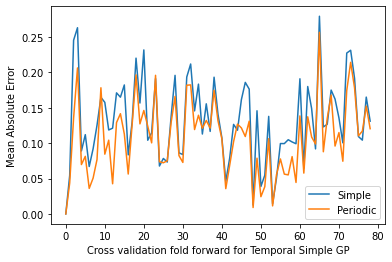

In [387]:
plt.plot(error_evolution_GP_ind_simple.values, label='Simple')
plt.plot(error_evolution_GP_ind_periodic.values, label='Periodic')
plt.legend()
plt.xlabel('Cross validation fold forward for Temporal Simple GP')
plt.ylabel('Mean Absolute Error')



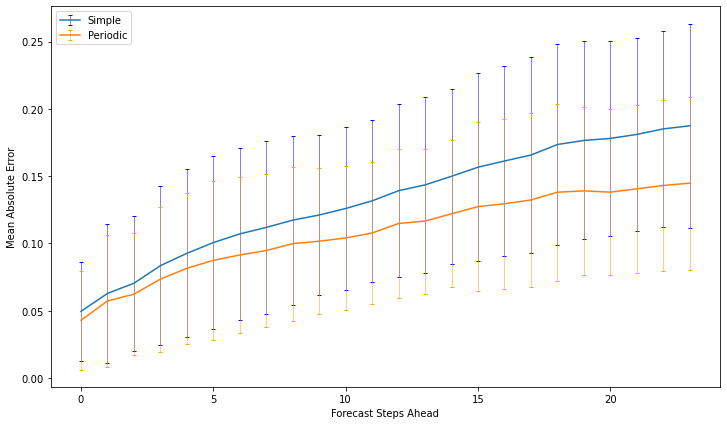

In [403]:
plt.figure(figsize=(12,7))
plt.errorbar(range(len(MAE_hsteps_GP_ind_simple)), MAE_hsteps_GP_ind_simple, errors_simple.std(axis=1), ecolor = 'blue', 
             elinewidth = 0.5, capsize=2, label='Simple')
plt.errorbar(range(len(MAE_hsteps_GP_ind_periodic)), MAE_hsteps_GP_ind_periodic, errors_periodic.std(axis=1), ecolor = 'orange', 
             elinewidth = 0.5, capsize=2, label='Periodic')
plt.legend()
plt.xlabel('Forecast Steps Ahead')
plt.ylabel('Mean Absolute Error');

In [482]:
MAE_hsteps_GP_ind_simple.mean()

0.13216093012713748

In [483]:
MAE_hsteps_GP_ind_periodic.mean()

0.10791727219361343

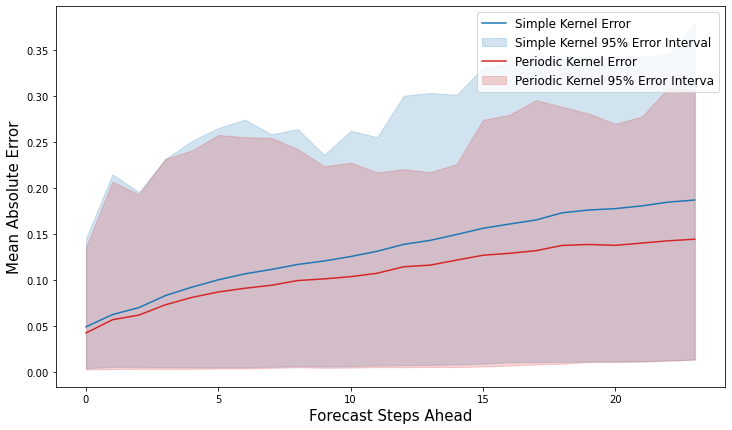

In [457]:
plt.figure(figsize=(12,7))
# plt.errorbar(range(len(MAE_hsteps_GP_ind_simple)), MAE_hsteps_GP_ind_simple, errors_simple.std(axis=1), ecolor = 'blue', 
#              elinewidth = 0.5, capsize=2, label='Simple')
plt.plot(MAE_hsteps_GP_ind_simple, color = 'C0', label = 'Simple Kernel Error')
plt.fill_between(MAE_hsteps_GP_ind_simple.index,
        errors_simple.quantile(0.025, axis=1),
        errors_simple.quantile(0.975, axis=1),
        color="C0",
        alpha=0.2, label = 'Simple Kernel 95% Error Interval')

plt.plot(MAE_hsteps_GP_ind_periodic, color = 'C3', label = 'Periodic Kernel Error')
plt.fill_between(MAE_hsteps_GP_ind_periodic.index,
        errors_periodic.quantile(0.025, axis=1),
        errors_periodic.quantile(0.975, axis=1),
        color="C3",
        alpha=0.2, label = 'Periodic Kernel 95% Error Interva')

plt.legend(fontsize= 12)
plt.xlabel('Forecast Steps Ahead', fontsize= 15)
plt.ylabel('Mean Absolute Error', fontsize= 15);

# plt.savefig('../figures/benchmark_ind_error_comparison.png', dpi=300, bbox_inches='tight')


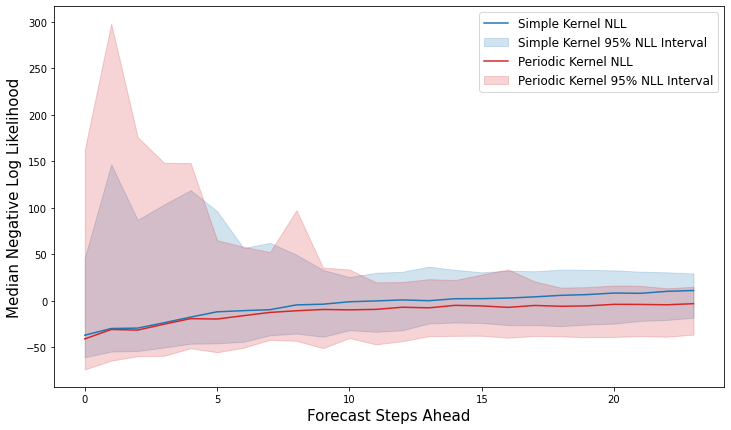

In [458]:
NLPD_df_GP_ind_periodic = pd.DataFrame.from_dict(NNLs_hsteps_GP_ind_periodic).rename(columns={0:'Periodic Kernel Temporal GP'})
NLPD_df_upper_GP_ind_periodic = pd.DataFrame.from_dict(NNLs_hsteps_upper_G_ind_periodic).rename(columns={0:'Periodic Kernel Temporal GP'})
NLPD_df_lower_GP_ind_periodic = pd.DataFrame.from_dict(NNLs_hsteps_lower_GP_ind_periodic).rename(columns={0:'Periodic Kernel Temporal GP'})

plt.figure(figsize=(12,7))

plt.plot(NLPD_df_GP_ind_simple, color="C0", label = 'Simple Kernel NLL')
plt.fill_between(NLPD_df_GP_ind_simple.index,
        NLPD_df_upper_GP_ind_simple.values[:,0],
        NLPD_df_lower_GP_ind_simple.values[:,0],
        color="C0",
        alpha=0.2, label = 'Simple Kernel 95% NLL Interval')

plt.plot(NLPD_df_GP_ind_periodic, color="C3", label = 'Periodic Kernel NLL')
plt.fill_between(NLPD_df_GP_ind_periodic.index,
        NLPD_df_upper_GP_ind_periodic.values[:,0],
        NLPD_df_lower_GP_ind_periodic.values[:,0],
        color="C3",
        alpha=0.2, label = 'Periodic Kernel 95% NLL Interval')

plt.xlabel('Forecast Steps Ahead', fontsize= 15)
plt.ylabel('Median Negative Log Likelihood', fontsize= 15)
plt.legend( fontsize= 12)
# plt.savefig('../figures/benchmark_ind_NLL_comparison.png', dpi=300, bbox_inches='tight')

# plt.ylim(-100,100)

In [487]:
NLPD_df_GP_ind_simple.mean(axis=0)

Simple Kernel Temporal GP   -4.994116
dtype: float64

In [488]:
NLPD_df_GP_ind_periodic.mean(axis=0)

Periodic Kernel Temporal GP   -12.604727
dtype: float64

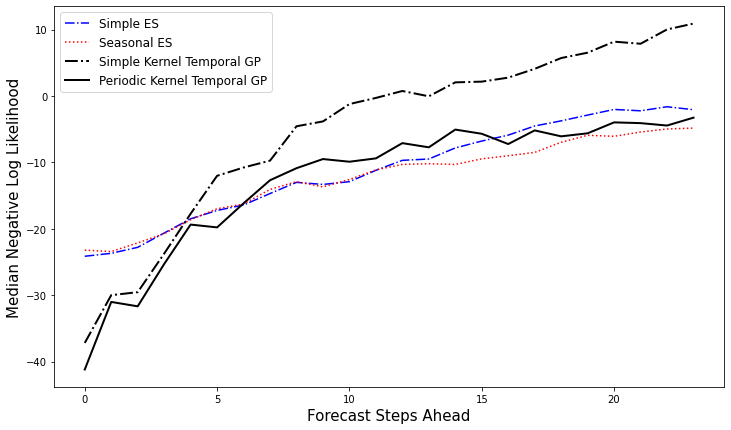

In [475]:
styles = ['-.', ':', '-']
colors = ['blue', 'red']

fig, ax = plt.subplots(figsize=(12,7))
for col, style, c in zip(likelihoods_df.columns[:2], styles, colors):
    likelihoods_df[col].plot(linestyle=style,  ax=ax, color = c)
#     plt.fill_between(likelihoods_df[col].index,
#         likelihoods_df_upper[col],
#         likelihoods_df_lower[col],
#         color="C2",
#         alpha=0.2)
    
# plt.ylim(-300, 200)

NLPD_df_GP_ind_simple.plot(ax=ax, linestyle='-.', color = 'k', linewidth=2)

# plt.fill_between(NLPD_df_GP_ind_simple.index,
#         NLPD_df_upper_GP_ind_simple.values[:,0],
#         NLPD_df_lower_GP_ind_simple.values[:,0],
#         color="C2",
#         alpha=0.2)

NLPD_df_GP_ind_periodic.plot(ax=ax, linestyle='-', color = 'k', linewidth=2)

# plt.fill_between(NLPD_df_GP_ind_periodic.index,
#         NLPD_df_upper_GP_ind_periodic.values[:,0],
#         NLPD_df_lower_GP_ind_periodic.values[:,0],
#         color="C3",
#         alpha=0.2)

plt.legend( fontsize= 12)
plt.xlabel('Forecast Steps Ahead', fontsize= 15)
plt.ylabel('Median Negative Log Likelihood', fontsize= 15)
plt.savefig('../figures/four_benchmarks_NLL_comparison.png', dpi=300, bbox_inches='tight')


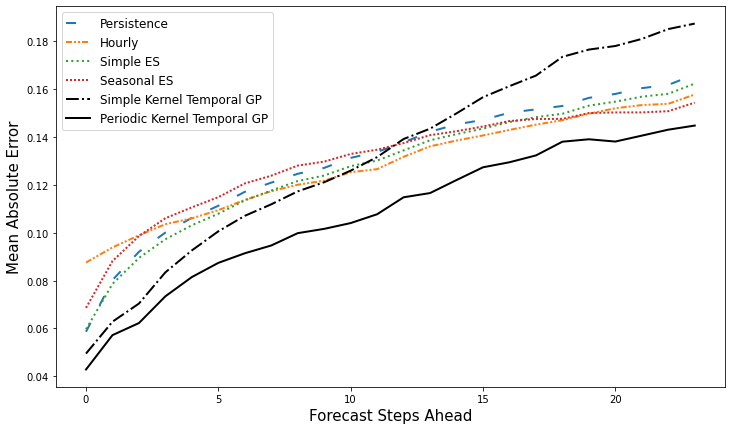

In [476]:
styles = [(0, (5, 10)),'-.',(0, (3, 1, 1, 1, 1, 1)), '--',':',(0, (1, 1))]

fig, ax = plt.subplots(figsize=(12, 7))
for col, style in zip(MAE_df.columns, styles):
    
    if (col == 'Yesterday') or (col == 'VAR'):
        continue
    
    MAE_df[col].plot(linestyle=style,  ax=ax, linewidth = 2)
    if col == 'ExponentialSmoothing':
        ax.fill_between(MAE_df[col].index,
            upper_error_benchmark[col],
            lower_error_benchmark[col],
            alpha=0.3, color = 'brown')
    
# ax.plot(MAE_hsteps_GP, label='Gaussian Process', linestyle='-', color = 'b')
# ax.fill_between(MAE_df[col].index,
#         np.quantile(errors_GP, 0.25, axis=1),
#         np.quantile(errors_GP, 0.75, axis=1),
#         alpha=0.1, color = 'b')


ax.plot(MAE_hsteps_GP_ind_simple, label='Simple Kernel Temporal GP', linestyle='-.', color = 'k', linewidth=2)

ax.plot(MAE_hsteps_GP_ind_periodic, label='Periodic Kernel Temporal GP', linestyle='-', color = 'k', linewidth=2)


plt.xlabel('Forecast Steps Ahead', fontsize= 15)
plt.ylabel('Mean Absolute Error', fontsize= 15);


plt.legend( fontsize= 12)
plt.savefig('../figures/six_benchmarks_error_comparison.png', dpi=300, bbox_inches='tight')





# Final: MAE AND NLL PLOTS OF BEST ST GP, BEST INDEPENDENT GP, AND BEST 2 BENCHMARKS


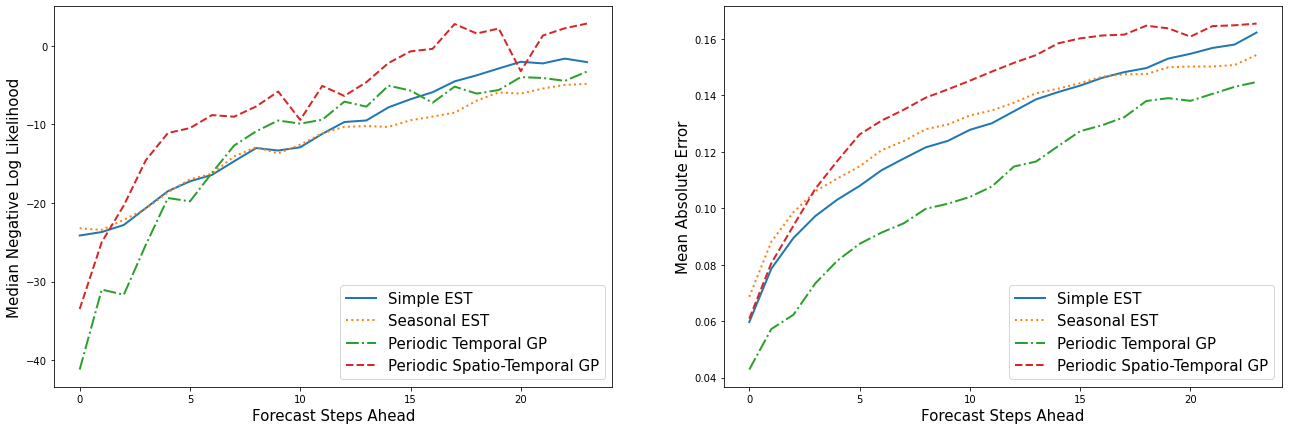

In [927]:
fig, ax = plt.subplots(1,2, figsize=(22,7))
ax[0].plot(likelihoods_df['Simple ES'], label = 'Simple EST' ,linestyle='-', linewidth=2)
ax[0].plot(likelihoods_df['Seasonal ES'], label = 'Seasonal EST',linestyle=':', linewidth=2)
ax[0].plot(NLPD_df_GP_ind_periodic, label = 'Periodic Temporal GP',linestyle='-.', linewidth=2)
ax[0].plot(NLPD_df_GP_21, label = 'Periodic Spatio-Temporal GP',linestyle='--', linewidth=2)

ax[0].set_xlabel('Forecast Steps Ahead',fontsize = 15)
ax[0].set_ylabel('Median Negative Log Likelihood',fontsize = 15);
ax[0].legend(fontsize = 15) 

ax[1].plot(MAE_df['Simple ES'], label = 'Simple EST' ,linestyle='-', linewidth=2)
ax[1].plot(MAE_df['Seasonal ES'], label = 'Seasonal EST',linestyle=':', linewidth=2)
ax[1].plot(MAE_hsteps_GP_ind_periodic, label = 'Periodic Temporal GP',linestyle='-.', linewidth=2)
ax[1].plot(MAE_hsteps_GP_21, label = 'Periodic Spatio-Temporal GP',linestyle='--', linewidth=2)

ax[1].set_xlabel('Forecast Steps Ahead',fontsize = 15)
ax[1].set_ylabel('Mean Absolute Error',fontsize = 15);
ax[1].legend(fontsize = 15) 

# plt.savefig('../figures/final_comparison_plot.png', dpi=300, bbox_inches='tight')
# 

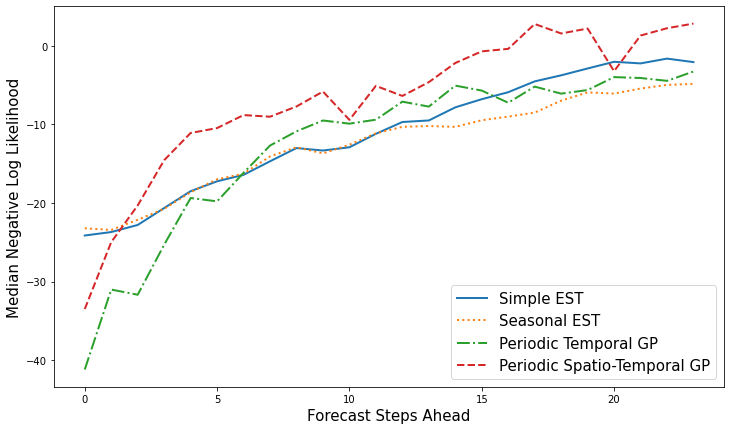

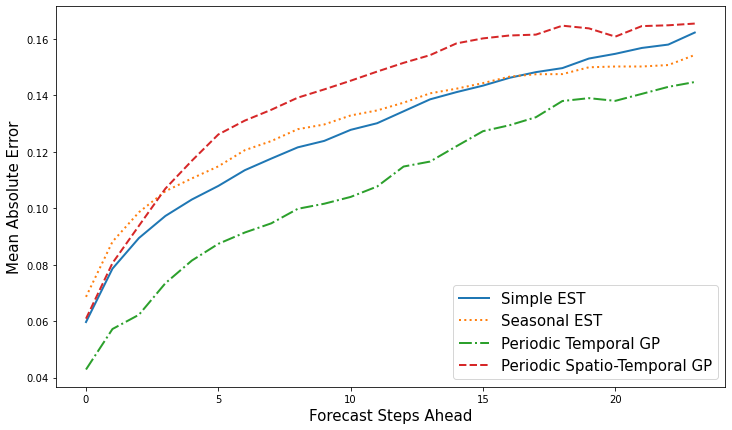

In [931]:
plt.figure(figsize=(12,7))
plt.plot(likelihoods_df['Simple ES'], label = 'Simple EST' ,linestyle='-', linewidth=2)
plt.plot(likelihoods_df['Seasonal ES'], label = 'Seasonal EST',linestyle=':', linewidth=2)
plt.plot(NLPD_df_GP_ind_periodic, label = 'Periodic Temporal GP',linestyle='-.', linewidth=2)
plt.plot(NLPD_df_GP_21, label = 'Periodic Spatio-Temporal GP',linestyle='--', linewidth=2)

plt.xlabel('Forecast Steps Ahead',fontsize = 15)
plt.ylabel('Median Negative Log Likelihood',fontsize = 15);
plt.legend(fontsize = 15) 
plt.savefig('../figures/final_comparison_plot_2.png', dpi=300, bbox_inches='tight')

plt.show()
   
plt.figure(figsize=(12,7))
plt.plot(MAE_df['Simple ES'], label = 'Simple EST' ,linestyle='-', linewidth=2)
plt.plot(MAE_df['Seasonal ES'], label = 'Seasonal EST',linestyle=':', linewidth=2)
plt.plot(MAE_hsteps_GP_ind_periodic, label = 'Periodic Temporal GP',linestyle='-.', linewidth=2)
plt.plot(MAE_hsteps_GP_21, label = 'Periodic Spatio-Temporal GP',linestyle='--', linewidth=2)

plt.xlabel('Forecast Steps Ahead',fontsize = 15)
plt.ylabel('Mean Absolute Error',fontsize = 15);
plt.legend(fontsize = 15) 
plt.savefig('../figures/final_comparison_plot_1.png', dpi=300, bbox_inches='tight')

plt.show()

# 